In [2]:
#ASE model

In [3]:
#long version of Read_LAMMPS_Submission_folders.ipynb

In [4]:
#imports:

from ase import Atom
from ase import Atoms
from ase.io import read, write
from ase.build import surface, cut
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from ase.visualize import view
from ase.constraints import FixedLine

import pyace

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import csv
import os
import re
import shutil
import subprocess
from scipy.interpolate import griddata



In [5]:
#Safty copy of the ML_Potential: /nfshome/karanikv/TU-Darmstadt-Work/Training_Potentials/2025_03_03_ReFitting_8_embending_functions_gpunode2/potential_iteration_1559_new_kappa_0p05.yaml in nfshome/okresa/
path_to_pot = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ML_Potential"
potential_name = "potential_iteration_1559_new_kappa_0p05.yaml"

print(f'Path_to_potential: {path_to_pot}/{potential_name}')
pot = pyace.PyACECalculator(f'{path_to_pot}/{potential_name}')


Path_to_potential: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ML_Potential/potential_iteration_1559_new_kappa_0p05.yaml


In [6]:
#define functions:
def gb_energy(atoms, eref_Cu, eref_Ag, xAg=0):
    a, b = atoms.cell[0], atoms.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    Energy_uncorrect = atoms.get_potential_energy()
    e = Corrected_Energy(Energy_uncorrect,atoms)
    return (e - len(atoms) *((1 - xAg) * eref_Cu + xAg * eref_Ag)) / (2*A)


def gb_energy_averaged(atoms, eref_Cu, eref_Ag, xAg=0):
    a, b = atoms.cell[0], atoms.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    #set e_avr variable after avaraging script
    return (e_avr - len(atoms) *((1 - xAg) * eref_Cu + xAg * eref_Ag)) / (2*A)


#Energy was omitted to fit a graph and must be recorrected
def Corrected_Energy(Energy_uncorrect,atoms):
    Number_Atoms = list(atoms.symbols)
    Ag_number = Number_Atoms.count('Ag')
    Cu_number = Number_Atoms.count('Cu')
    Ga_number = Number_Atoms.count('Ga')
    Se_number = Number_Atoms.count('Se')
    
    E_Ag = -0.07060507
    E_Cu = -0.06457733
    E_Ga = -0.07974831
    E_Se = -0.16179301
    return Energy_uncorrect + Ag_number*E_Ag + Cu_number*E_Cu + Ga_number*E_Ga + Se_number*E_Se


def optimize(atoms, fmax=0.1, write=False, fname=None):
    # Constrain each atom individually along the z-direction
    indices1 = [atom.index for atom in atoms]
    #c = FixedLine(indices=indices, direction=[0, 0, 1])
    indices = list(range(len(atoms)))  # Ensure indices is a list of atom indices
    CC = []
    for index in indices:
        CC.append(FixedLine(index, [0, 0, 1]))
    atoms.set_constraint(CC)

    # Initialize and run the BFGS optimizer
    opt = BFGS(atoms)
    opt.run(fmax=fmax,steps=250)

    # Optionally write the optimized structure to a file
    if write:
        if fname:
            atoms.write("{}".format(fname), vasp5=True, direct=True, sort=True)
        else:
            atoms.write("opt.POSCAR", vasp5=True, direct=True, sort=True)

    return None


def optimize1(atoms, fmax=0.001, mask=(1, 1, 1, 0, 0, 0), write=False, fname=None):
    opt = BFGS(atoms)
    opt.run(fmax=fmax,steps=250)
    ucf = UnitCellFilter(atoms,constant_volume=True, mask=mask)
    #ucf = UnitCellFilter(atoms,constant_volume=False, mask=mask)
    opt = BFGS(ucf)
    opt.run(fmax=fmax,steps=250)
    if write:
        if fname:
            atoms.write("{}".format(fname), vasp5=True, direct=True, sort=True)
        else:
            atoms.write("opt.POSCAR", vasp5=True, direct=True, sort=True)

    return None


In [7]:
#Referece bulk energy (Eb) <--------- needs to be corrrected again

ref_Cu = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2.POSCAR")
ref_Cu.set_calculator(pot)
optimize1(ref_Cu,write=True, fname="/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR")
eref_Cu = ref_Cu.get_potential_energy() / len(ref_Cu)
#---------------------
#eref_Cu_uncorrected = ref_Cu.get_potential_energy() / len(ref_Cu)
#eref_Cu = Corrected_Energy(eref_Cu_uncorrected,ref_Cu) #E_b (reference bulk energy per Atom)
#---------------------
print(f"\nRefecrence Bulk Energy Cu: {eref_Cu}\n") #problem: at T=0K

ref_Ag = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/AgGaSe2.POSCAR")
ref_Ag.set_calculator(pot)
optimize1(ref_Ag,write=True, fname="/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/AgGaSe2_rel.POSCAR")
#eref_Ag = ref_Ag.get_potential_energy() / len(ref_Ag)
#---------------------
eref_Ag_uncorrected = ref_Ag.get_potential_energy() / len(ref_Ag)
eref_Ag = Corrected_Energy(eref_Ag_uncorrected,ref_Ag)
#---------------------
print(f"\nRefecrence Bulk Energy Ag: {eref_Ag}\n")

print("Note: should be close to -3.898 in Vac ver.")
print("\n\nDONE")

      Step     Time          Energy          fmax
BFGS:    0 18:55:30      -60.539534        0.030474
BFGS:    1 18:55:30      -60.539633        0.026715
BFGS:    2 18:55:30      -60.539964        0.000007
      Step     Time          Energy          fmax
BFGS:    0 18:55:30      -60.539964        0.033752
BFGS:    1 18:55:30      -60.539988        0.033623
BFGS:    2 18:55:30      -60.543144        0.014454
BFGS:    3 18:55:30      -60.543166        0.012604
BFGS:    4 18:55:30      -60.543242        0.000416

Refecrence Bulk Energy Cu: -3.7839526323936408

      Step     Time          Energy          fmax
BFGS:    0 18:55:30      -56.023459        0.006862
BFGS:    1 18:55:30      -56.023464        0.006095
BFGS:    2 18:55:30      -56.023483        0.000000
      Step     Time          Energy          fmax
BFGS:    0 18:55:31      -56.023483        0.019965
BFGS:    1 18:55:31      -56.023492        0.019907
BFGS:    2 18:55:31      -56.024944        0.008026
BFGS:    3 18:55:31    

/tmp/ipykernel_3513221/3902203599.py:4: DeprecationWarning: Please use atoms.calc = calc
  ref_Cu.set_calculator(pot)
/tmp/ipykernel_3513221/4070876573.py:59: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms,constant_volume=True, mask=mask)
/tmp/ipykernel_3513221/3902203599.py:14: DeprecationWarning: Please use atoms.calc = calc
  ref_Ag.set_calculator(pot)


BFGS:    5 18:55:31      -56.024977        0.000255

Refecrence Bulk Energy Ag: -5.397318665252235

Note: should be close to -3.898 in Vac ver.


DONE


In [8]:
#common target for graphs in docs:
common_graph_folder = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection"
common_graph_path = Path(common_graph_folder) 

print(common_graph_path)

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection


In [9]:
#.glob(): This method is used to search for files or directories matching a specific pattern within base_path.
#         * is a wildcard matching any characters (zero or more).

In [45]:


#opt 1 and 2 read



Enter the LAMMPS index (e.g., 001, 002, ... etc.):  009


Folder name for 009 is: LAMMPS_Submision_009_01-04-2025_17-50-00
Atoms in Supercell: n = 1144
GB Area: A = 157.1053133579634 Å²


/tmp/ipykernel_3320196/345423092.py:57: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490717 eV
GB Formation Energy:
-5.8992071936478006 J/m²
2reps_done

Atoms in Supercell: n = 2296
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-8938.419505712107 eV
GB Formation Energy:
-12.771332244961817 J/m²
4reps_done

Atoms in Supercell: n = 3448
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-13432.305230938493 eV
GB Formation Energy:
-19.643457296530624 J/m²
6reps_done

Atoms in Supercell: n = 4600
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-17926.190956164875 eV
GB Formation Energy:
-26.51558234809915 J/m²
8reps_done



/tmp/ipykernel_3320196/345423092.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


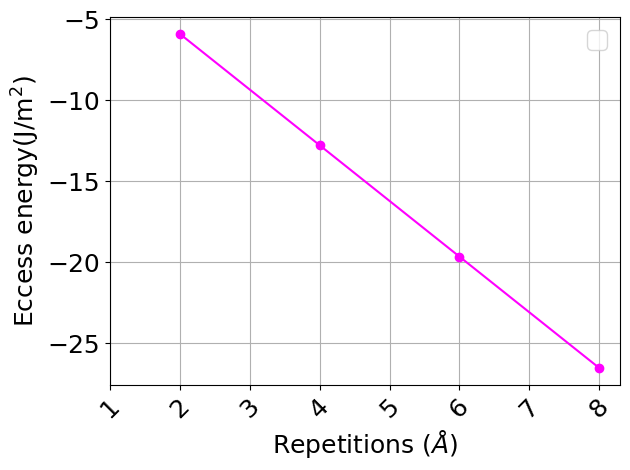


Timestamp:
03-05-2025 12:33


In [15]:
#Up to DATE 31_03_2025 custom input version

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~12 min + extra time to finish on the gpu node

# Ask the user for the LAMMPS index
LAMMPS_index = []
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
formation_Energy = []
repeat = []

# List all directories in the base directory
base_path = Path(base_dir)

# Find the folder name matching the pattern for LAMMPS_Submision
folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Loop through the files matching the pattern
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue  # Skip this file and go to the next one
    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        print("GB Area: A =", A, "Å²")
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        """
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
        """
        formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
        print(f"{rep}reps_done\n")
        repeat.append(rep)

#plot formation energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt1.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  013


Folder name for 013 is: LAMMPS_Submision_013_02-05-2025_17-11-28
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_013_02-05-2025_17-11-28/8_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize1.data


/tmp/ipykernel_3320196/3881189052.py:92: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-1483.1560129263605 eV
GB Formation Energy:
-1.53574630891464 J/m²
The Energy (per atom) is: -3.862385450329064 in eV per atom
12layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_013_02-05-2025_17-11-28/8_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_24z-layers.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize1.data
Supercell potential Energy:
-2981.1117126055888 eV
GB Formation Energy:
-3.8261380723621423 J/m²
The Energy (per atom) is: -3.881655875788527 in eV per atom
24layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_013_02-05-2025_17-11-28/8_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_36z-layers.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize1.data
Supercell potential Energy:
-4479.0746312168185 eV
GB Formation Energy:
-6.11689

NameError: name 'submission_graph_path' is not defined

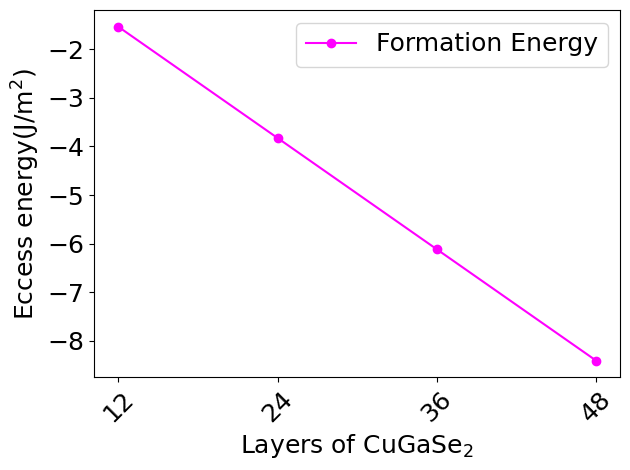

In [22]:
#Up to DATE 03_05_2025 custom input version (does not reference ral bulk!!!)

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~12 min + extra time to finish on the gpu node

# Ask the user for the LAMMPS index
LAMMPS_index = []
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []
layer = []
bulk_layer = []
layers = []
bulk_layers = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# List all directories in the base directory
base_path = Path(base_dir)

# Find the folder name matching the pattern for LAMMPS_Submision
folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Loop through the files matching the pattern
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue  # Skip this file and go to the next one
    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping rep based files: No repetition found")
            #continue  # Skip if no repetition is found
            
        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            layer = int(layer_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found
        
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        Total_Energy.append(e_pot)

        #calc formation_energy
        Formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²

        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        if rep:
            print(f"{rep}reps_done\n")
            repeat.append(rep)
        if layer:
            print(f"{layer}layers_done\n")
            layers.append(layer)



#plot formation energy over repetitions of the supercell

print("Formation_energy_v2")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    #plt.ylabel('GB Formation energy in [J/m$^2$]', fontsize=18)
    plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
    plt.yticks(fontsize=18)
    # Optional: dynamic y-axis tick range
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.ylabel('GB Formation energy (J/m$^2$)', fontsize=18)
    plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
    plt.yticks(fontsize=18)
    # Optional dynamic ticks again
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_opt1_E_B_from_ref.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_ref.png", bbox_inches='tight') 
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  009


Folder name for 009 is: LAMMPS_Submision_009_01-04-2025_17-50-00
Atoms in Supercell: n = 1144
GB Area: A = 161.3360963754785 Å²


/tmp/ipykernel_4839/489866280.py:57: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4439.778055474788 eV
GB Formation Energy:
100.80787835091462 J/m²
2reps_done

Atoms in Supercell: n = 2296
GB Area: A = 161.2549304360852 Å²
Supercell potential Energy:
-8929.089270569142 eV
GB Formation Energy:
201.50419834904716 J/m²
4reps_done

Atoms in Supercell: n = 3448
GB Area: A = 161.27605806169052 Å²
Supercell potential Energy:
-13417.764672803902 eV
GB Formation Energy:
302.1417773757614 J/m²
6reps_done

Atoms in Supercell: n = 4600
GB Area: A = 161.61698071053635 Å²
Supercell potential Energy:
-17903.878304077887 eV
GB Formation Energy:
402.083035951864 J/m²
8reps_done

[2, 4, 6, 8]


/tmp/ipykernel_4839/489866280.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


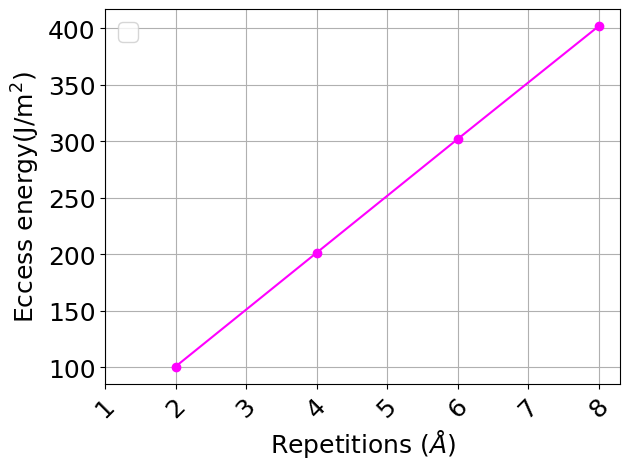


Timestamp:
01-04-2025 19:09


In [47]:
#Up to DATE 31_03_2025 custom input version

#Read output optimize2 out of _Xrep... mini.data folders
#note LAMMPS 8 rep takes ~42 min + extra time to write output

# Ask the user for the LAMMPS index
LAMMPS_index = []
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
formation_Energy = []
repeat = []

# List all directories in the base directory
base_path = Path(base_dir)

# Find the folder name matching the pattern for LAMMPS_Submision
folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Loop through the files matching the pattern
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize2.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue  # Skip this file and go to the next one
    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        print("GB Area: A =", A, "Å²")
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        """
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
        """
        formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
        print(f"{rep}reps_done\n")
        repeat.append(rep)
        #print(repeat)

#plot formation energy over repetitions of the supercell
print(repeat)

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt2.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  009


Folder name for 009 is: LAMMPS_Submision_009_01-04-2025_17-50-00
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-2rep_10A_VACUUMS.data


/tmp/ipykernel_4839/4117265202.py:73: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


2reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-4rep_10A_VACUUMS.data
4reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-6rep_10A_VACUUMS.data
6reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-8rep_10A_VACUUMS.data
8reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data


/tmp/ipykernel_4839/4117265202.py:102: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


2reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data
4reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data
6reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data
8reps_done


The Total Energies are: [-4444.533780490717, -8938.419505712107, -13432.305230938493, -17926.190956164875] (in eV)
The Bulk energies E_b are: [-4450.283415140807, -8944.169140367174, -13438.054865593613, -17931.940590819926] (in eV)
The Total energies per atom are: [-3.885081975953424, -3.8930398544042277, -

/tmp/ipykernel_4839/4117265202.py:147: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


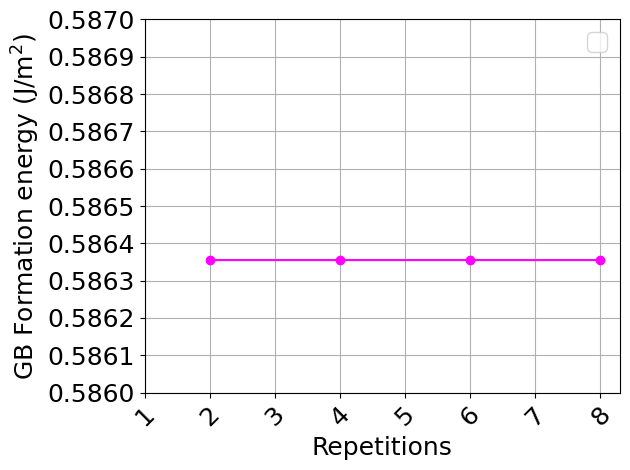

/tmp/ipykernel_4839/4117265202.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


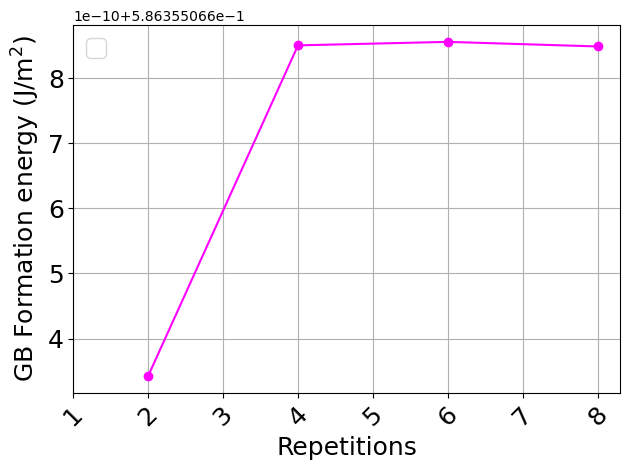


Timestamp:
01-04-2025 19:09


In [48]:
#01_04_2025 custom input version

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy with the E_B reference LAMMPS bulk

#short ver.

# Ask the user for the LAMMPS index
#LAMMPS_index = '008'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
base_dir = f"{project_dir}/data/LAMMPS_Data"

# Clear preexisting variables
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

# List all directories in the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        print(Path(grandparent_folder))
        # If the folder does contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            bulk_rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(bulk_rep_str)
        else:
            print(f"Skipping rep based file: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        #n_bulk_reps.append(len(atoms1))
        e_bulk_uncorrected = atoms1.get_potential_energy()
        e_bulk = Corrected_Energy(e_bulk_uncorrected, atoms1)
        #print("Bulk potential Energy:")
        #print(e_bulk, "eV")
        
        Bulk_Energy.append(e_bulk)
        #divide by atom count (needed?)
        Undivided_Energy = e_bulk
        Divided_Energy = Undivided_Energy/len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        #print(f"The bulk Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{bulk_rep}reps_done\n")
        bulk_repeat.append(bulk_rep)        

    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping rep based file: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        #print("Supercell potential Energy:")
        #print(e_pot, "eV")

        Total_Energy.append(e_pot)
        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{rep}reps_done\n")
        repeat.append(rep)

print(f"\nThe Total Energies are: {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are: {Bulk_Energy} (in eV)")

print(f"The Total energies per atom are: {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms1.cell[0], atoms1.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: plot formation energy over repetitions of the supercell: 2 variants for scale:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
plt.yticks(np.arange(0.586, 0.587, 0.0001))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()


plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
#plt.yticks(np.arange(0.5, 1.05, 0.05))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_opt1_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  009


Folder name for 009 is: LAMMPS_Submision_009_01-04-2025_17-50-00
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-2rep_10A_VACUUMS.data


/tmp/ipykernel_4839/3121216936.py:78: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Bulk potential Energy:
-4450.283415140807 eV
The bulk Energy (per atom) is: -3.890107880367838 in eV per atom
2reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-4rep_10A_VACUUMS.data
Bulk potential Energy:
-8944.169140367174 eV
The bulk Energy (per atom) is: -3.895544050682567 in eV per atom
4reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-6rep_10A_VACUUMS.data
Bulk potential Energy:
-13438.054865593613 eV
The bulk Energy (per atom) is: -3.897347698838055 in eV per atom
6reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-8rep_10A_VACUUMS

/tmp/ipykernel_4839/3121216936.py:107: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490717 eV
The Energy (per atom) is: -3.885081975953424 in eV per atom
2reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data
Supercell potential Energy:
-8938.419505712107 eV
The Energy (per atom) is: -3.8930398544042277 in eV per atom
4reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data
Supercell potential Energy:
-13432.305230938493 eV
The Energy (per atom) is: -3.895680171385874 in eV per atom
6reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VAC

/tmp/ipykernel_4839/3121216936.py:151: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


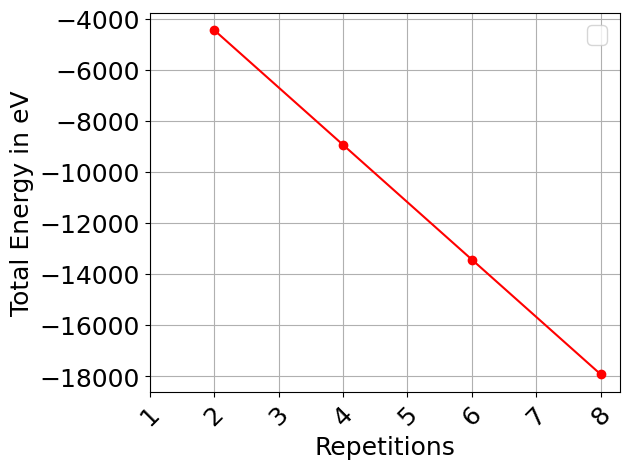


The Total Energies are (red): [-4444.533780490717, -8938.419505712107, -13432.305230938493, -17926.190956164875] (in eV)
The Bulk energies E_b are (orange): [-4450.283415140807, -8944.169140367174, -13438.054865593613, -17931.940590819926] (in eV)


/tmp/ipykernel_4839/3121216936.py:173: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


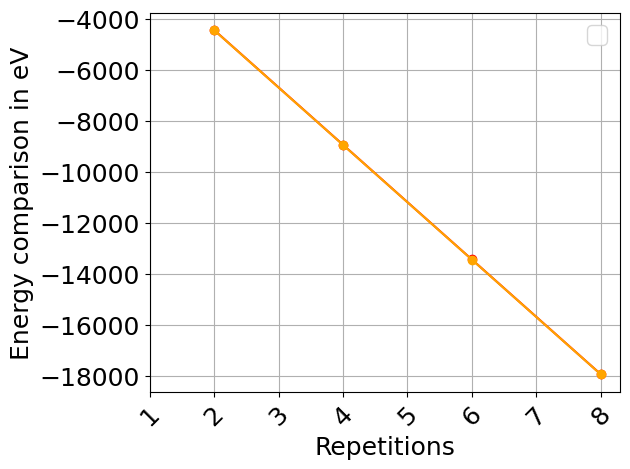


Testing:
The Total energies per atom are: [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948886]
The Bulk energies per Atom are: [-3.890107880367838, -3.895544050682567, -3.897347698838055, -3.898247954526071] (in eV per Atom)
The Energy difference per Atom is: [0.005025904414414306, 0.002504196278339421, 0.0016675274521809058, 0.001249920577185204] (in eV per Atom)
The Energy difference is: [5.749634650089966, 5.749634655067311, 5.749634655119763, 5.749634655051938] (in eV)
The Energy difference per Area of the GB is: [0.03659732778731335, 0.03659732781899493, 0.036597327819328805, 0.03659732781889709] (in eV/Å²)
The Energy difference per Area of the GB is: [0.586355066342777, 0.586355066850373, 0.5863550668557223, 0.5863550668488053] (in J/m²)
The Energy difference is: [5.749634650089966, 5.749634655067311, 5.749634655119763, 5.749634655051938] (in eV)


/tmp/ipykernel_4839/3121216936.py:222: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


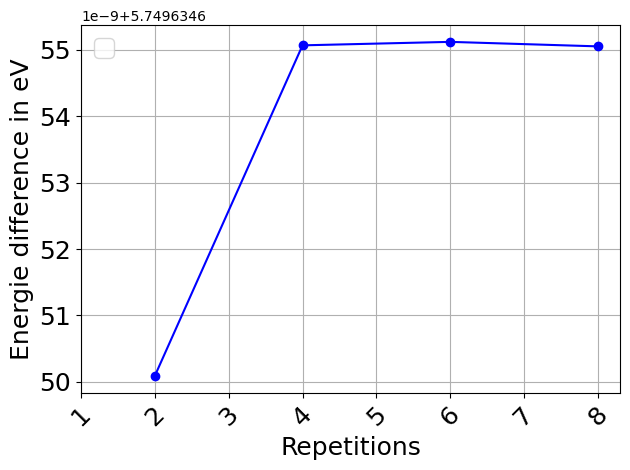



The Total energies per atom are (red): [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948886] (in eV per Atom)
The Bulk energies per Atom are (orange): [-3.890107880367838, -3.895544050682567, -3.897347698838055, -3.898247954526071] (in eV per Atom)


/tmp/ipykernel_4839/3121216936.py:245: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


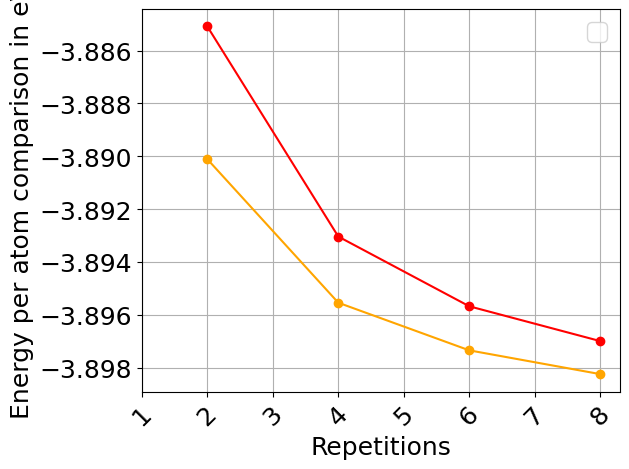

The Energy difference per Atom is: [0.005025904414414306, 0.002504196278339421, 0.0016675274521809058, 0.001249920577185204] (in eV)


/tmp/ipykernel_4839/3121216936.py:266: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


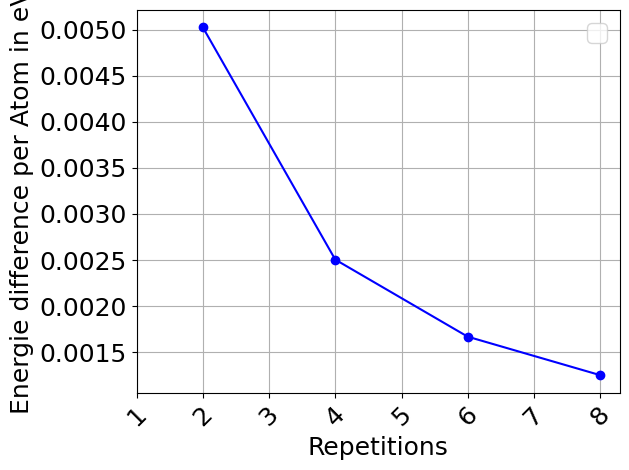



The formation energies are: [0.5863550663428039, 0.5863550668503397, 0.5863550668557194, 0.5863550668486701]


/tmp/ipykernel_4839/3121216936.py:288: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


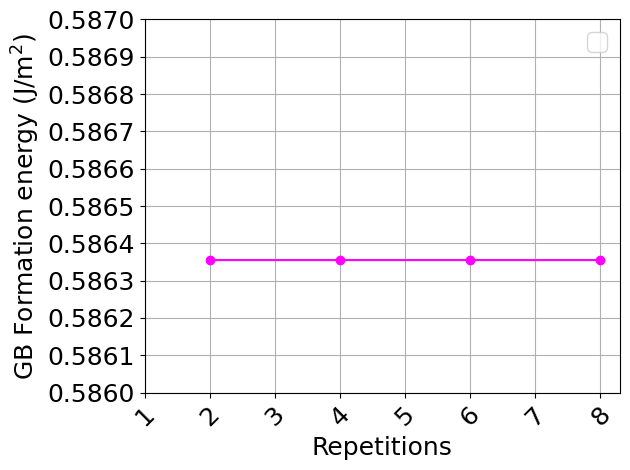

/tmp/ipykernel_4839/3121216936.py:307: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


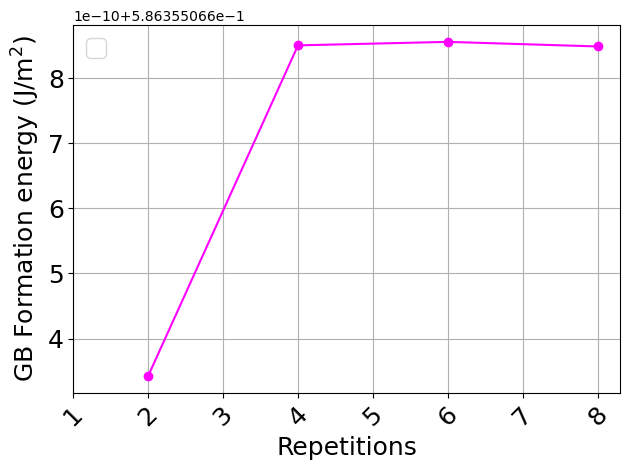


Timestamp:
01-04-2025 19:09


In [49]:
#01_04_2025 custom input version || only old format (up to index 009)

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy with the E_B reference LAMMPS bulk

#needs short ver.

# Ask the user for the LAMMPS index
#LAMMPS_index = '008'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# List all directories in the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_opt1_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        print(Path(grandparent_folder))
        # If the folder does contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            bulk_rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(bulk_rep_str)
        else:
            print(f"Skipping rep based file: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        #n_bulk_reps.append(len(atoms1))
        e_bulk_uncorrected = atoms1.get_potential_energy()
        e_bulk = Corrected_Energy(e_bulk_uncorrected, atoms1)
        print("Bulk potential Energy:")
        print(e_bulk, "eV")
        Bulk_Energy.append(e_bulk)
        
        #divide by atom count (needed?)
        Undivided_Energy = e_bulk
        Divided_Energy = Undivided_Energy/len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        print(f"The bulk Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{bulk_rep}reps_done\n")
        bulk_repeat.append(bulk_rep)

    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping rep based files: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        Total_Energy.append(e_pot)
        
        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{rep}reps_done\n")
        repeat.append(rep)

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms1.cell[0], atoms1.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
else:
    plt.plot(np.asarray(layer),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

#for i in range(4):
    #Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()


# Step 11: plot formation energy over repetitions of the supercell: 2 variants for scale:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
plt.yticks(np.arange(0.586, 0.587, 0.0001))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()


plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
#plt.yticks(np.arange(0.5, 1.05, 0.05))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_formation_comparison(x_values, formation_energy, x_label_title="Repetitions ($\AA$)"):
    """
    Plots GB Formation Energy in linear scale and log10 of the difference
    relative to the first energy value for sensitivity analysis.
    
    Parameters:
    - x_values: List[int or float] - x-axis values (e.g., repetitions or layers)
    - formation_energy: List[float] - GB formation energies
    - x_label_title: str - Label for the x-axis (default is for repetitions)
    """

    # Compute log10 of delta energies (from first value)
    ref_energy = formation_energy[0]
    log_deltas = [np.log10(abs(e - ref_energy) + 1e-12) for e in formation_energy]  # Add small value to avoid log(0)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

    # --- Plot 1: Linear Scale ---
    ax1.plot(x_values, formation_energy, marker='o', color='magenta', label='Formation Energy')
    ax1.set_title("Linear Scale", fontsize=14)
    ax1.set_xlabel(x_label_title, fontsize=12)
    ax1.set_ylabel("GB Formation Energy (J/m$^2$)", fontsize=12)
    ax1.tick_params(axis='both', labelsize=10)
    ax1.grid(True)
    for x, y in zip(x_values, formation_energy):
        ax1.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

    # --- Plot 2: Log10 of Differences ---
    ax2.plot(x_values, log_deltas, marker='o', color='darkgreen', label='log₁₀(|ΔE|)')
    ax2.set_title("Log10 of ΔEnergy from First", fontsize=14)
    ax2.set_xlabel(x_label_title, fontsize=12)
    ax2.set_ylabel("log₁₀(|ΔE|)", fontsize=12)
    ax2.tick_params(axis='both', labelsize=10)
    ax2.grid(True)
    for x, y in zip(x_values, log_deltas):
        ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

"""
repeat = [2, 4, 6, 8]
Formation_Energy = [0.5861139108739761, 0.5863546822087751, 0.5863550663442879, 0.5863550668508961]
"""

repeat = []
layers = [12, 24, 36, 48]
Formation_Energy = [0.5861139108739761, 0.5863546822087751, 0.5863550663442879, 0.5863550668508961]


# Example usage (choose based on available data)
if repeat:
    plot_formation_comparison(repeat, Formation_Energy, "Repetitions ($\AA$)")
else:
    plot_formation_comparison(layers, Formation_Energy, "Layers of CuGaSe2 ($\AA$)")

In [50]:









#thermo-data read:










In [51]:
#All-in-one-systematic:

Rep count is 2reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_006_19-03-2025_17-39-59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data/T_1000/thermo_data.csv


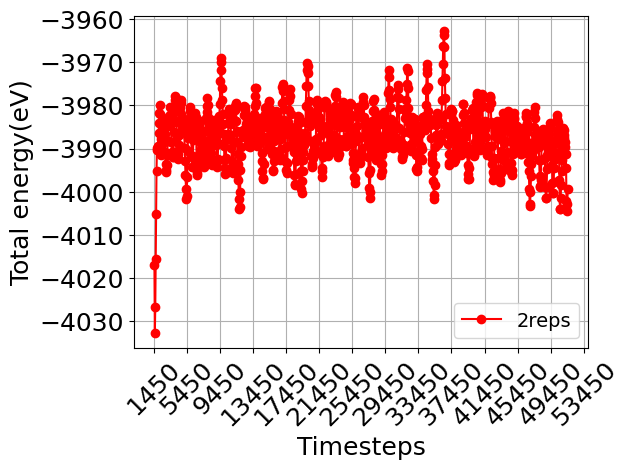

/tmp/ipykernel_4839/2320795863.py:150: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="14", loc ="lower right")


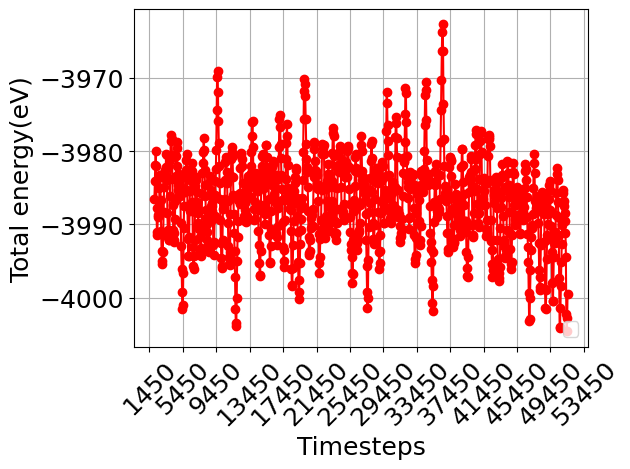

The average of the Energy is: -3986.9920714738823 in eV
The Energy (per atom) is: -3.485132929610037 in eV per atom

Rep count is 4reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_006_19-03-2025_17-39-59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data/T_1000/thermo_data.csv


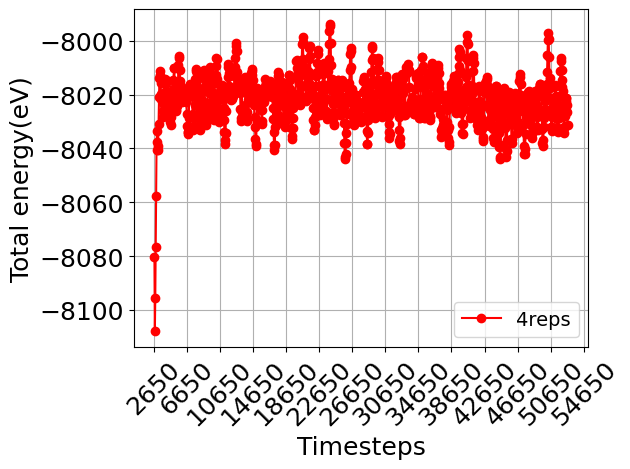

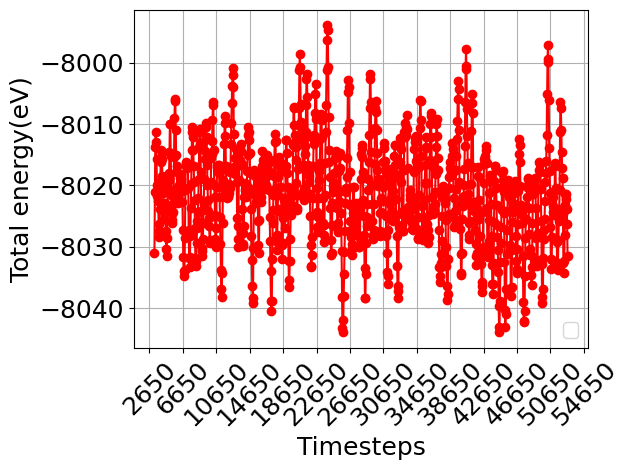

The average of the Energy is: -8021.4202221010755 in eV
The Energy (per atom) is: -3.49364992251789 in eV per atom

Rep count is 6reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_006_19-03-2025_17-39-59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.csv


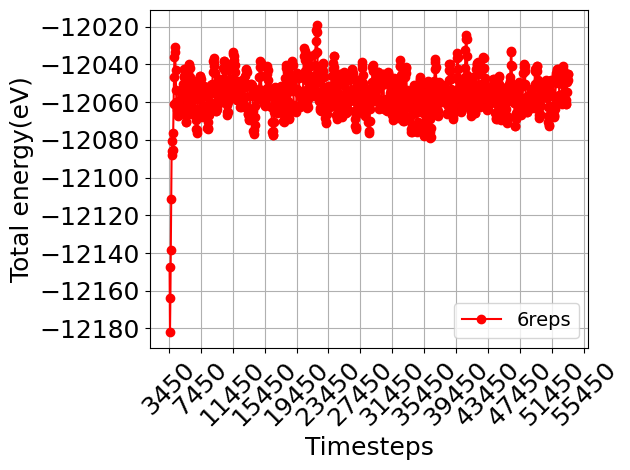

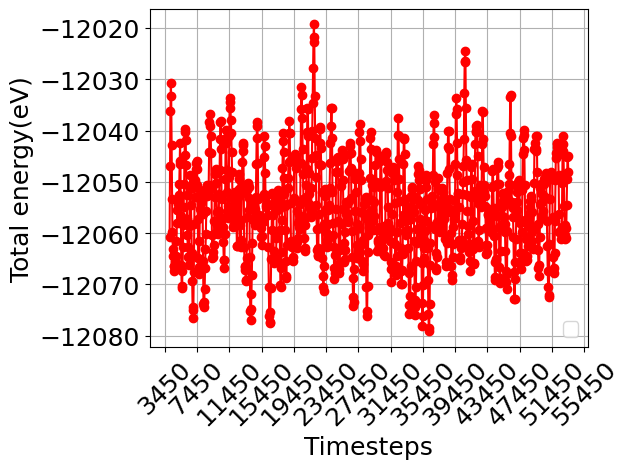

The average of the Energy is: -12055.258911640483 in eV
The Energy (per atom) is: -3.4963047887588408 in eV per atom

Rep count is 8reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_006_19-03-2025_17-39-59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data/T_1000/thermo_data.csv


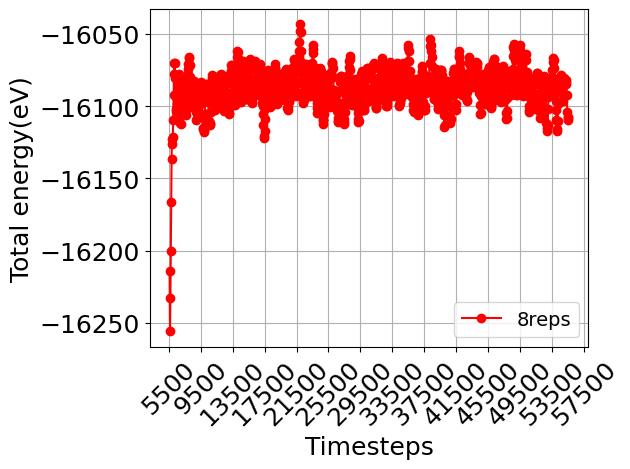

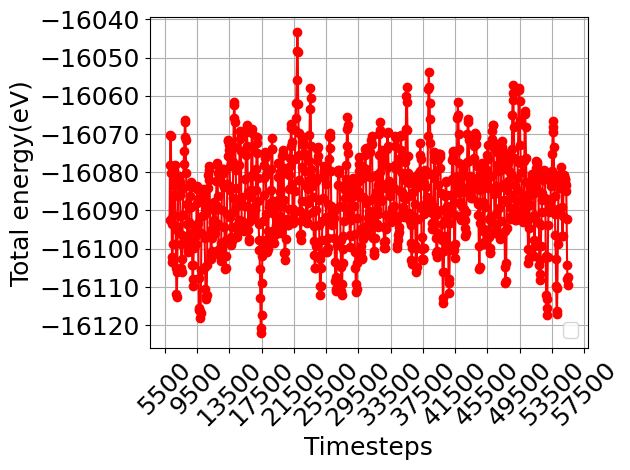

The average of the Energy is: -16087.058534739932 in eV
The Energy (per atom) is: -3.4971866379869416 in eV per atom


For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Total Energy per atom is: [-3.485132929610037, -3.49364992251789, -3.4963047887588408, -3.4971866379869416] (in eV per atom)
The Total Energy is: [-3986.9920714738823, -8021.4202221010755, -12055.258911640483, -16087.058534739932] (in eV)
The Area of the GB is: 157.30529027915497 (in Å²)
The Area of the GB is: 161.61698071053635 (in Å²)

kB is: 8.617333262000001e-05
The Bulk Energy temp scaling Term kBT is: 0.08617333262000001 (in eV per Atom)

The Bulk Energy per Atom is: -5.655599272393642 (in eV per Atom)
The Bulk energies E_b are: [-6470.0055676183265, -12985.255929415804, -19500.506291213278, -26015.756653010754]
The Bulk Energy (+ kBT Term) per Atom is: -5.569425939773643 (in eV per Atom)
The Bulk energies (+ kBT Term) E_b are: [-6371.423275101048, -12787.401957720283

/tmp/ipykernel_4839/2320795863.py:275: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


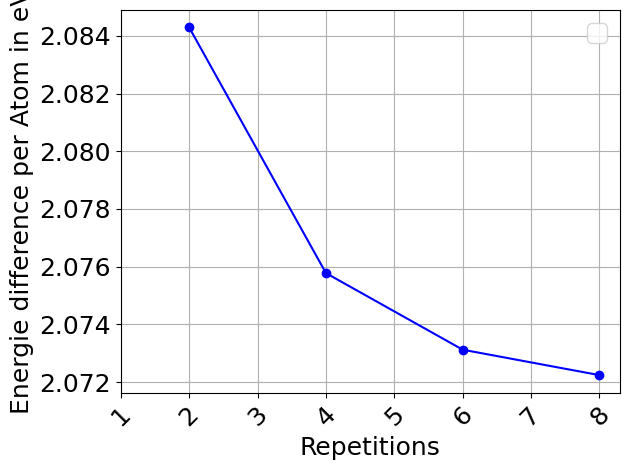

The Energy difference is: [2384.431203627165, 4765.981735619208, 7148.121728699038, 9532.300788218825] (in eV)


/tmp/ipykernel_4839/2320795863.py:294: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


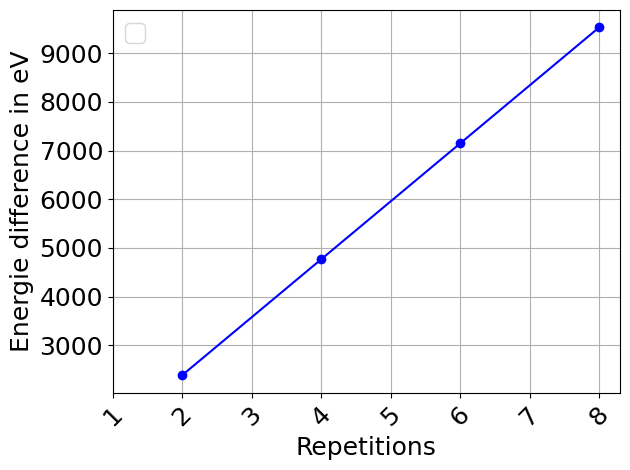



The Total energies per atom are: [-3.485132929610037, -3.49364992251789, -3.4963047887588408, -3.4971866379869416]


/tmp/ipykernel_4839/2320795863.py:317: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


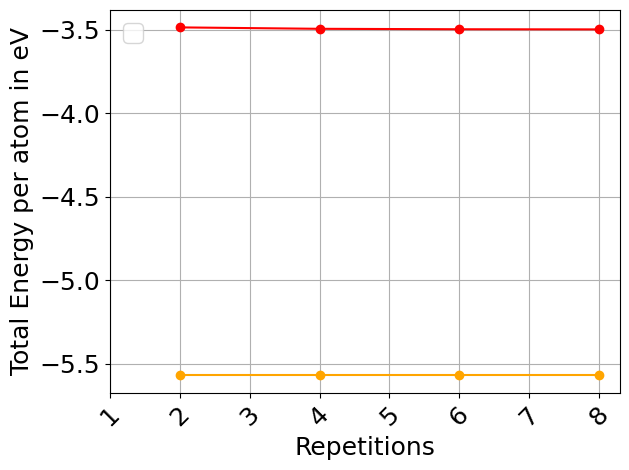



The formation energies are: [78.7930403730222, 157.4908895423299, 236.20821733245825, 314.9929256551356]


/tmp/ipykernel_4839/2320795863.py:339: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


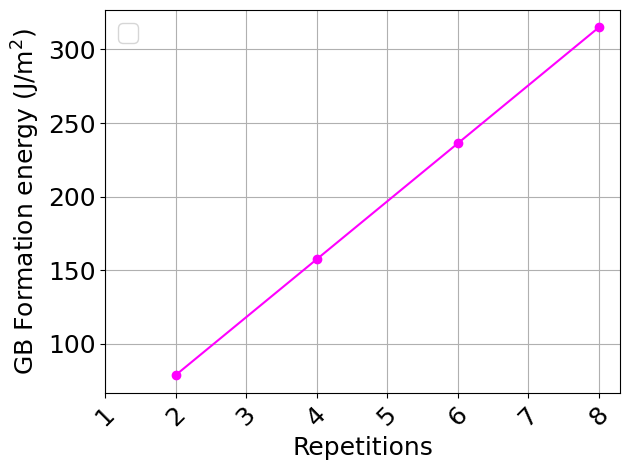


Timestamp:
01-04-2025 19:09


In [52]:
#UP to date 31_03_2025

#Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K
#Use the calculated reference Bulk E_B

import csv

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Total_Energy = [] #needed later
Total_Energy_per_atom = [] #needed later
n_reps = [] #needed later
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    base_file_path = f"{core_path}/LAMMPS_Submision_006_19-03-2025_17-39-59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14-44-31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    if rep_count == repeat[0]:
        print(f"Rep count is {rep_count}reps\n")
    else:
        print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")

    
    # Step 4: plot the Energy over the Timesteps
        
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep_count}reps",color='red')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Total energy(eV)",fontsize = 18)
    plt.tight_layout()

    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
       
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    
    
    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label='',color='red')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
    
    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Total_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Total_Energy_per_atom.append(Divided_Energy)
    print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
    

# Step 9: calculate formation energy for each repetition

print("\n")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is: {Total_Energy} (in eV)")

xAg = 0
A = 157.30529027915497
print(f"The Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")
#kB = 1.380649*(10^(-23)) #in (m^2 kg s^-2 K^-1 or J K^-1)
#Mit Elektronenvolt (eV) als Energieeinheit hat die Boltzmann-Konstante den – ebenfalls exakten – Wert 8.617333262*(10^(-5)) (eV/K)
kB = 8.617333262*(10**(-5))
print(f"\nkB is: {kB}")
#note that Test = 10^(-5) #--> =-15!!! --> use Test = 10**(-5)
temp_scaling_term = (kB*Temp)       #kB*T characteristic energy kBT associated with a single microscopic degree of freedom, (1DoF)
                                    #where T denotes temperature and kB denotes the Boltzmann constant.

print(f"The Bulk Energy temp scaling Term kBT is: {temp_scaling_term} (in eV per Atom)\n")

Bulk_Energy = []
formation_Energy = []

E_bulk_per_atom = (((1 - xAg) * eref_Cu + xAg * eref_Ag)) 
#print(f"The Bulk Energy per Atom is: {eref_Cu} (in eV per Atom)")
print(f"The Bulk Energy per Atom is: {E_bulk_per_atom} (in eV per Atom)")


# Loop over the energies and calculate formation energy
for i in range(4):
    Bulk_Energy.append(n_reps[i] * E_bulk_per_atom)
    eform = (((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (3 * A))* 16.0218) #3 Flächen von interesse 2 Oberflächen und die KG
    formation_Energy.append(eform)                                                   # 16.0218 Conversion factor from eV/Å² to J/m²

print(f"The Bulk energies E_b are: {Bulk_Energy}")

E_bulk_per_atom = (((1 - xAg) * eref_Cu + xAg * eref_Ag)+temp_scaling_term)

print(f"The Bulk Energy (+ kBT Term) per Atom is: {E_bulk_per_atom} (in eV per Atom)")

Bulk_Energy = []
formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    Bulk_Energy.append(n_reps[i] * E_bulk_per_atom)
    eform = (((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (3 * A))* 16.0218) #3 Flächen von interesse 2 Oberflächen und die KG
    formation_Energy.append(eform)                                                   # 16.0218 Conversion factor from eV/Å² to J/m²

#print(E_bulk_per_atom)
print(f"The Bulk energies (+ kBT Term) E_b are: {Bulk_Energy}")


#Testing:
#KEIN fehler in der Formel !!!
Bulk_Energy_per_Atom = []
Ediff = []
Ediff_per_area = []
Ediff_per_Atom = []
Ediff_per_area_inJ = []
for i in range(4):
    Bulk_Energy_per_Atom.append(Bulk_Energy[i]/n_reps[i])
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies (+ kBT Term) per Atom is: {Bulk_Energy_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_Atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_Atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_Atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(3*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

#plot Ediff per atom over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_Atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print(f"The Energy difference is: {Ediff} (in eV)")

#plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print("\n")
print(f"The Total energies per atom are: {Total_Energy_per_atom}")

#plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_Atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy per atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print("\n")
print(f"The formation energies are: {formation_Energy}")

# Step 10: plot formation energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
#UP to date 01_04_2025 REWORKED:
#Read thermo-data| usefull for Figure 4 --> 015 for opt2 long MD

#All-in-one-systematic thermo-calc read:
#rewritten to ask for user input
#Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K 
#with E-B reference out of LAMMPS

# Ask the user for the LAMMPS index
#LAMMPS_index = '009'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables: (needs to be cleaned up)
# new
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

#carry over:
Formation_Energy = []

rep = []
bulk_rep = []
rep_count = []
repeat = []
bulk_repeat = []
n_reps = []

e_pot = []
e_bulk = []
Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# Path of the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_opt2_thermo_data_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

#WARNING,sorts by timestamp, not name!!!
#causes issue whe editing LAMMPS_Submision
for folder in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*"):
    # Get the parent directory of the file
    parent_folder = folder.parent
    #grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    #if "BULK" in grandparent_folder.name:
    if "BULK" in parent_folder.name:
        # If the folder does contain "BULK", process the file
     
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{bulk_rep}")
        else:
            print(f"Skipping file {data_folder.name}: No repetition found")
            continue  # Skip if no repetition is found

        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file

        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        bulk_repeat.append(bulk_rep)
        #if rep_count == repeat[0]:
        #    print(f"Rep count is {rep_count}reps\n")
        #else:
        #    print(f"\nRep count is {rep_count}reps\n")
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        #print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")

        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
    
        # Step 2.4: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{bulk_rep}reps",color='orange')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="best")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Bulk energy(eV)",fontsize = 18)
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') 
        plt.show()
        #if rep_count == 2:
        #    plt.show()
    
        
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
    
        # Step 2.6: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{bulk_rep}reps",color='orange')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight')
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight')
        plt.show()
        #if rep_count == 2:
        #    plt.show()
    
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        #print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Bulk_Energy.append(averaged_Energy)
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Bulk_Energy_per_atom.append(Divided_Energy)
        #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

        #Extra Step:
        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW
        # Add the new variable to store temperatures
        second_column = []  # Create an empty list to store the second column (Temperature)

        # Step 2.2: Read the second column (Temperature) of the .csv file starting from the second row
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns (timesteps, temperature, energy)
                    try:
                        # Convert the 2nd column value (Temperature) to float and append to the list
                        second_column.append(float(row[1]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[1]} to a float. Skipping it.")

        # Output the second column (Temperature) as a list
        # print(second_column)
        list_length = len(second_column)
        # print(f"The length of the second_column list is: {list_length}")

        #Extra Step 2: Plot the Temperature over the Timesteps
        """#v1
        plt.plot(np.asarray(first_column), np.asarray(second_column), marker='o', label=f"Temperature", color='green')
        plt.grid(True)
        plt.legend(fontsize="14", loc="best")
        plt.xticks(rotation=45)
        plt.xticks(fontsize=18)
        plt.xticks(np.arange(min(first_column) - 100, max(first_column) + 4000, 4000))
        plt.xlabel('Timesteps', fontsize=18)
        plt.yticks(fontsize=18)
        plt.ylabel('Temperature (K)', fontsize=18)  # Temperature in Kelvin
        plt.tight_layout()

        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """

        """#v2
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        time_in_ps = np.array(first_column) * 0.001  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Temperature", color='darkred')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first
        # Display only every nth timestep label on the second x-axis (e.g., every 2nd timestep)
        n = 1000  # Change this value to display every nth label
        ticks_to_display = first_column[::n]  # Select every nth timestep
        time_labels = time_in_ps[::n]  # Corresponding time labels in ps
        ax2.set_xticks(ticks_to_display)
        ax2.set_xticklabels([f"{t:.3f}" for t in time_labels])  # Format time labels to 3 decimal places
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """

        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Temperature", color='darkred')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Create a second y-axis (right side) for Bulk Energies
        ax3 = ax1.twinx()  # This shares the same x-axis but adds a new y-axis on the right

        # Plot Bulk Energies
        ax3.plot(first_column, third_column, marker='o', label="Bulk Energies", color='orange')

        # Customize second y-axis (right side)
        ax3.set_ylabel('Bulk Energy (eV)', fontsize=18)
        ax3.tick_params(axis='y', labelsize=14)
        #ax3.set_ylabel('Bulk Energy (units)', fontsize=18, color='orange')
        #ax3.tick_params(axis='y', labelsize=14, labelcolor='orange')

        # Optional: add second legend (if you want both legends)
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_3, labels_3 = ax3.get_legend_handles_labels()
        #ax1.legend(lines_1 + lines_3, labels_1 + labels_3, loc='best', fontsize=14)
        ax1.legend(lines_1 + lines_3, labels_1 + labels_3, loc='lower right', fontsize=14)


        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight')
        plt.show()

        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW

    else:
        # If the folder does not contain "BULK", process the file    
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{rep}")
        else:
            print(f"Skipping file {data_folder.name}: No repetition found")
            continue  # Skip if no repetition is found
            
        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
        
        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        repeat.append(rep)
        
        if rep_count == repeat[0]:
            print(f"Rep count is {rep}reps\n")
        else:
            print(f"\nRep count is {rep}reps\n")
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")
    
        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
        
        # Step 2.4: plot the Energy over the Timesteps
            
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Total energy(eV)",fontsize = 18)
        plt.tight_layout()
    
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') 
        plt.show()
        #if rep_count == 2:
        #    plt.show()
           
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
        
        # Step 2.6: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') 
        plt.show()
        #if rep_count == 2:
        #    plt.show()
        
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Total_Energy.append(averaged_Energy)
        n_reps.append(len(atoms2))
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW
        
        #Extra Step 2: Plot the Temperature over the Timesteps
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Temperature", color='darkred')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Create a second y-axis (right side) for Bulk Energies
        ax3 = ax1.twinx()  # This shares the same x-axis but adds a new y-axis on the right

        # Plot Bulk Energies
        ax3.plot(first_column, third_column, marker='o', label="Total Energies", color='red')

        # Customize second y-axis (right side)
        ax3.set_ylabel('Total Energy (eV)', fontsize=18)
        ax3.tick_params(axis='y', labelsize=14)
        #ax3.set_ylabel('Bulk Energy (units)', fontsize=18, color='orange')
        #ax3.tick_params(axis='y', labelsize=14, labelcolor='orange')

        # Optional: add second legend (if you want both legends)
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_3, labels_3 = ax3.get_legend_handles_labels()
        #ax1.legend(lines_1 + lines_3, labels_1 + labels_3, loc='best', fontsize=14)
        ax1.legend(lines_1 + lines_3, labels_1 + labels_3, loc='lower right', fontsize=14)
        
        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_GB_Temperature_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_GB_Temperature_thermo_data_full.png", bbox_inches='tight')
        plt.show()

        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW
        
        #Extra Step 3: Plot the Energies over the Timesteps AND Time
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, third_column, marker='o', label="Total Energies", color='red')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)
      
        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_GB_Total_Energies_time_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_GB_Total_Energies_time_thermo_data_full.png", bbox_inches='tight')
        plt.show()

        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW

        # Extra Step 4: total bar comparison

        # Assuming 'third_column' is already defined
        first_value = third_column[0]
        last_value = third_column[-1]

        # Bar chart setup
        fig, ax = plt.subplots(figsize=(6, 4))

        # Set the bar width (adjust this value to change the thickness)
        bar_width = 0.4  # You can change this value for thicker or thinner bars
        # Set padding (space between bars and the plot's edges)
        left_padding = 1  # Amount of space added to the left of the bars
        right_padding = 1  # Amount of space added to the right of the bars
        #extra_height_padding = 9000  # Add extra space above the highest bar
        extra_height_padding = 0  # Add extra space above the highest bar
        #label_height_offset = 1000  # Change this value to control label height
        label_height_offset = -100  # Change this value to control label height
        bar_view_range = 500 # Change this value to control the visible window of the bars

        # Positioning the bars with padding
        bar_positions = np.array([0, 1])  # Initial positions for the 'First' and 'Last' bars
        bar_positions += left_padding  # Apply left padding by shifting the positions
        bar_positions[-1] -= right_padding  # Apply right padding by shifting the last bar's position

        # Bar chart (comparing the first and last values)
        bars = ax.bar(['Start', 'Finish'], [first_value, last_value], color=['red', 'red'], width=bar_width)

        # Add labels and title
        ax.set_ylabel('Total Energy in [eV]', fontsize=14)
        ax.set_title('Comparison of first and last Total Energy Values', fontsize=16)

        # Get the min and max values (to ensure the plot accommodates negative values)
        y_min = min(first_value, last_value)
        y_max = max(first_value, last_value)

        # Adjust the y-axis limits to focus on a window from 2000 below the min to 2000 above the max
        #y_min_adjusted = y_min - 1000
        #y_max_adjusted = y_max + 1000
        y_min_adjusted = y_min - bar_view_range
        y_max_adjusted = y_max + bar_view_range



        # Set the y-axis limits with the adjusted values
        ax.set_ylim(y_min_adjusted, y_max_adjusted)

        # Adjust the y-axis limits to include both negative and positive values
        #ax.set_ylim(y_min - extra_height_padding, y_max + extra_height_padding)

        # Optional: add values on top of bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + label_height_offset, round(yval, 2), ha='center', fontsize=12)

        # Adjust the x-axis limits to prevent bars from touching the edges
        ax.set_xlim(-0.5, len(bar_positions) - 0.5)

        # Show the plot
        plt.tight_layout()  # Adjust layout for better spacing
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_GB_Total_Energies_Box_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_GB_Total_Energies_Box_thermo_data_full.png", bbox_inches='tight')
        plt.show()

        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

"""
#sort:
#print(repeat)
repeat = sorted(repeat)
#print(repeat)
#print(n_reps)
n_reps = sorted(n_reps)
#print(n_reps)
#print(Bulk_Energy)
Bulk_Energy = sorted(Bulk_Energy, reverse = True)
#print(Bulk_Energy)
Total_Energy = sorted(Total_Energy, reverse = True)
"""
               
# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Total_Energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Total_Energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 9: print values for the Bulk Energy

print("For the Bulk Energy:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Bulk Energy per atom is: {Bulk_Energy_per_atom} (in eV per atom)")
print(f"The Bulk Energy is (orange): {Bulk_Energy} (in eV)")

# Step 10: plot BULK energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('BULK energy (eV)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/ref_Bulk_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/ref_Bulk_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_comparison_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

#for i in range(4):
#    Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_difference_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()


# Step 11: plot formation energy over repetitions of the supercell:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Rep count is 2reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-2rep_10A_VACUUMS.data/T_1000/thermo_data.csv


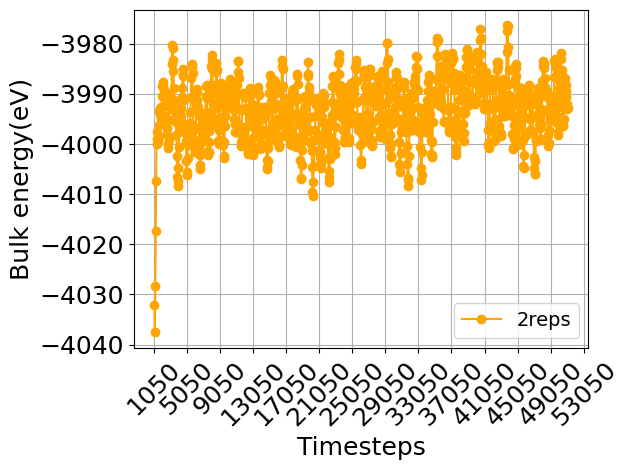

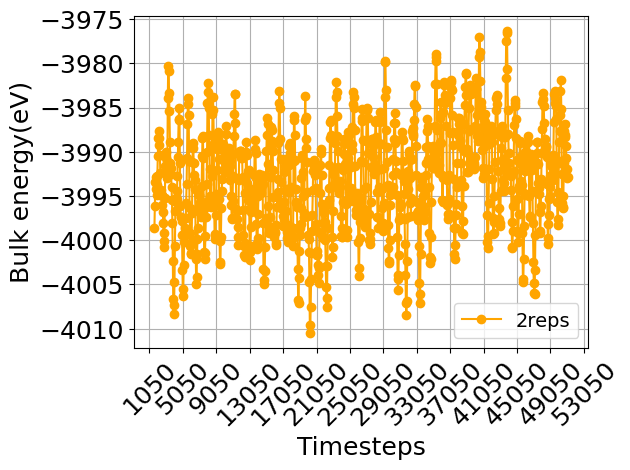

The average of the Energy is: -3993.092815690117 in eV
The Energy (per atom) is: -3.4904657479808714 in eV per atom

Rep count is 4reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-4rep_10A_VACUUMS.data/T_1000/thermo_data.csv


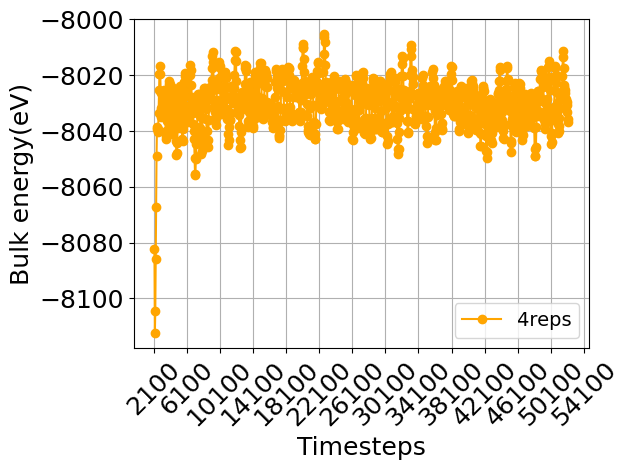

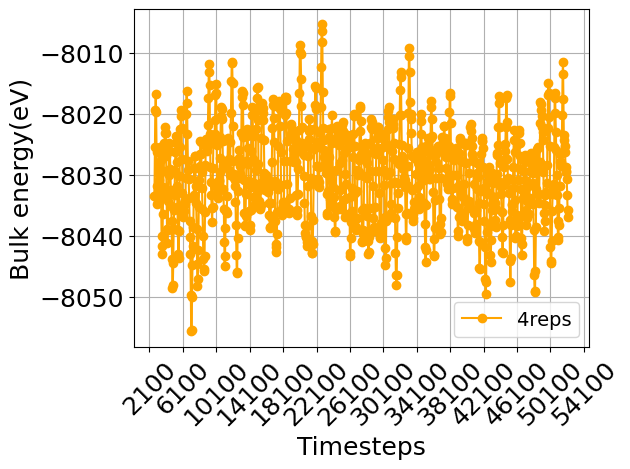

The average of the Energy is: -8029.99431505763 in eV
The Energy (per atom) is: -3.4973842835616855 in eV per atom

Rep count is 6reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.csv


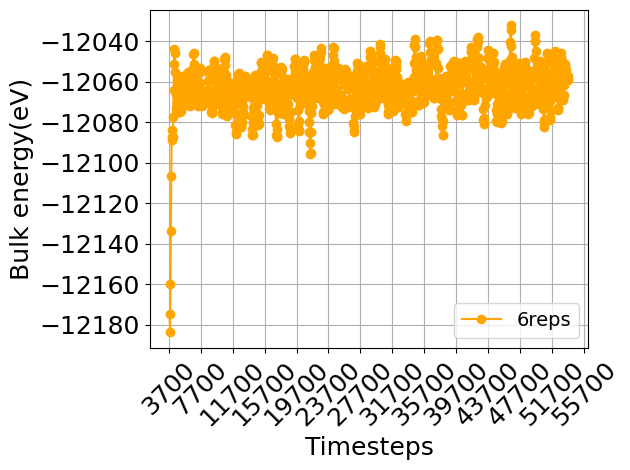

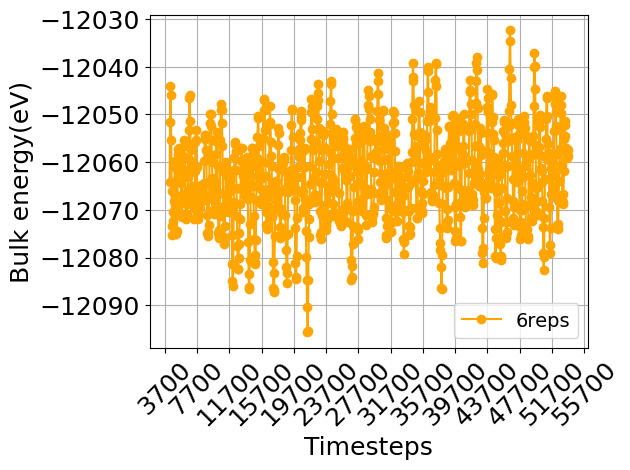

The average of the Energy is: -12062.77247198676 in eV
The Energy (per atom) is: -3.4984838955878073 in eV per atom

Rep count is 8reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-8rep_10A_VACUUMS.data/T_1000/thermo_data.csv


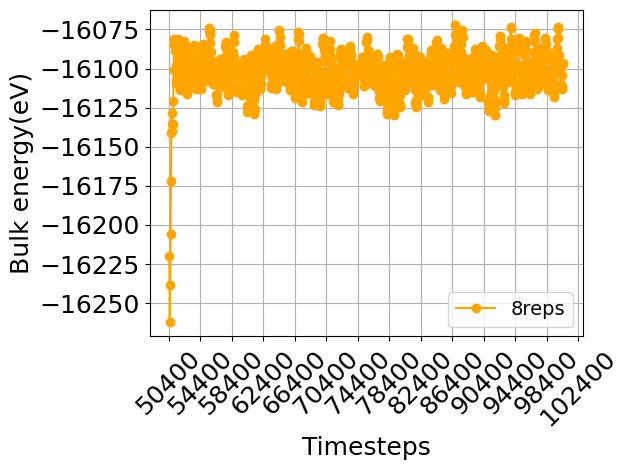

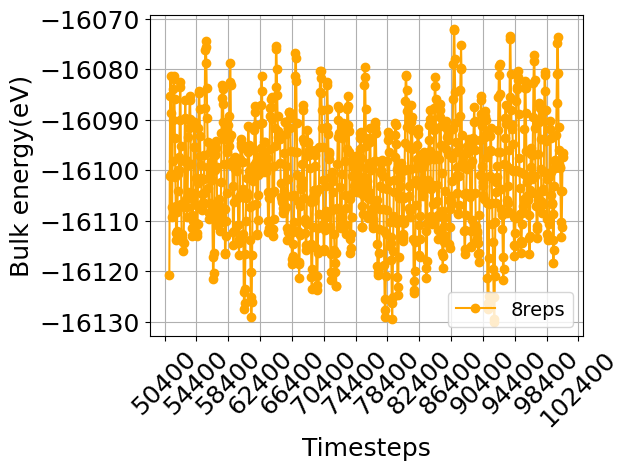

The average of the Energy is: -16101.256415140519 in eV
The Energy (per atom) is: -3.5002731337262 in eV per atom

For the Bulk Energy:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Bulk Energy per atom is: [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per atom)
The Bulk Energy is: [-3993.092815690117, -8029.99431505763, -12062.77247198676, -16101.256415140519] (in eV)


/tmp/ipykernel_4839/3659637312.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


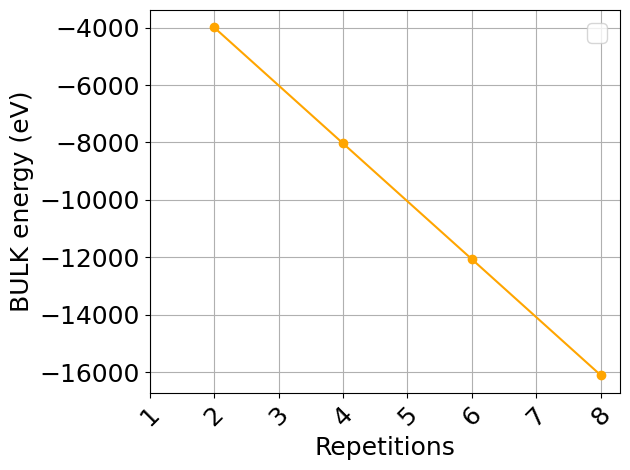


Timestamp:
01-04-2025 15:55


In [14]:
#Calculating the E_b Bulk_Energy of a Bulk (with 20Å Vacuum on both sides) that has been put through MD at 1000K

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Bulk_Energy = [] #needed later
Bulk_Energy_per_atom = [] #needed later
n_reps = [] #needed later
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    #MD_S9_mini_BULK is a bit of a misnomer (S9 should be removed) but if would have to change the folder creation skript 
    #maybe fix if this part becomes standard procedure
    base_file_path = f"{core_path}/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14-44-31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    if rep_count == repeat[0]:
        print(f"Rep count is {rep_count}reps\n")
    else:
        print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")


    # Step 4: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep_count}reps",color='orange')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Bulk energy(eV)",fontsize = 18)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
    
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    
    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep_count}reps",color='orange')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Bulk_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Bulk_Energy_per_atom.append(Divided_Energy)
    print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")


# Step 9: print values

print("\nFor the Bulk Energy:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Bulk Energy per atom is: {Bulk_Energy_per_atom} (in eV per atom)")
print(f"The Bulk Energy is: {Bulk_Energy} (in eV)")

# Step 10: plot BULK energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('BULK energy (eV)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/ref_Bulk_energy_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()




# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format





In [53]:
                                                         #/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/L
#AMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data/T_1000/optimize2.data

In [54]:
#in batch 8: err in 8rep ver ---> needs to be checked

In [55]:
#WIP-all-in-one-systematic:

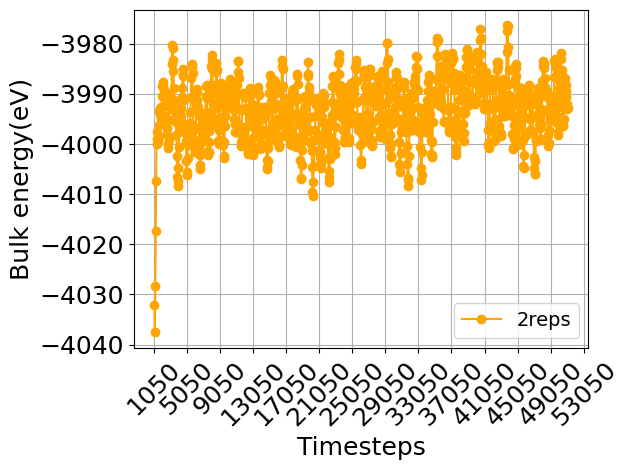

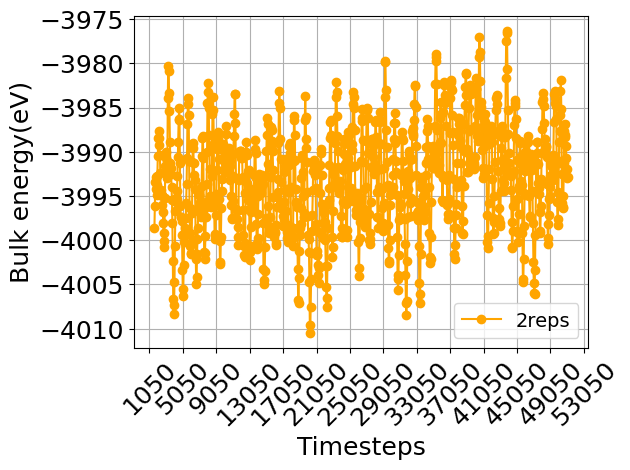

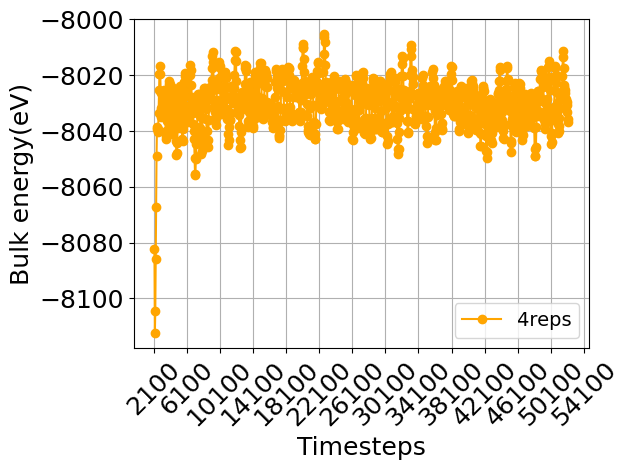

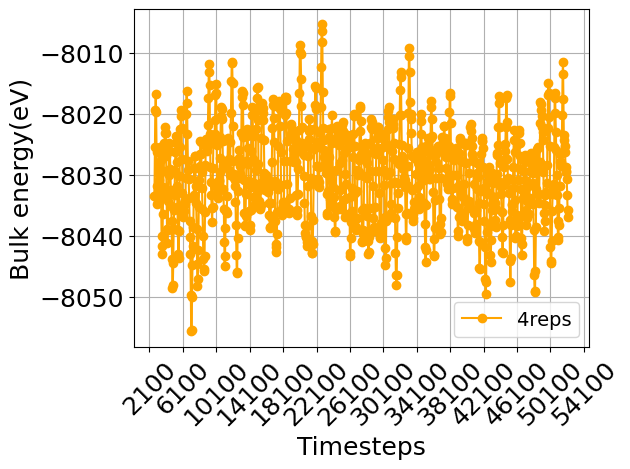

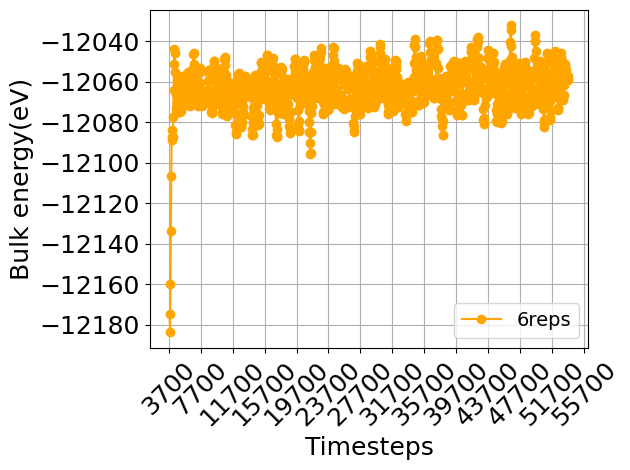

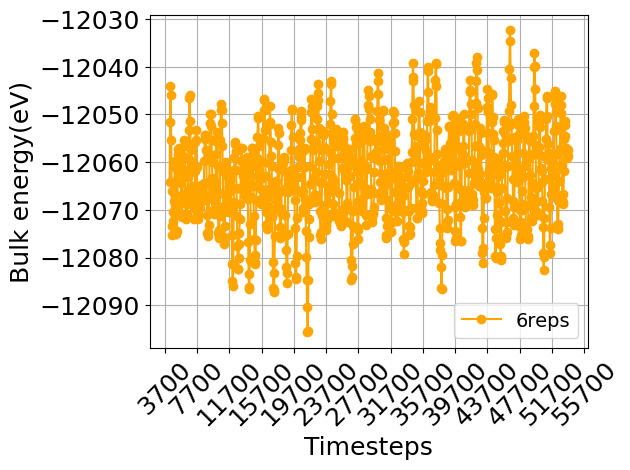

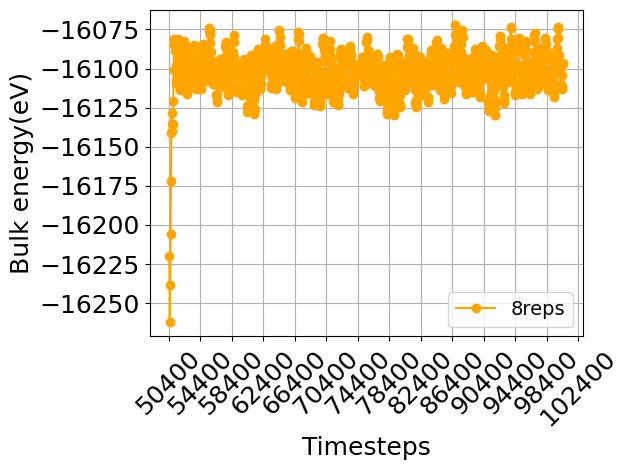

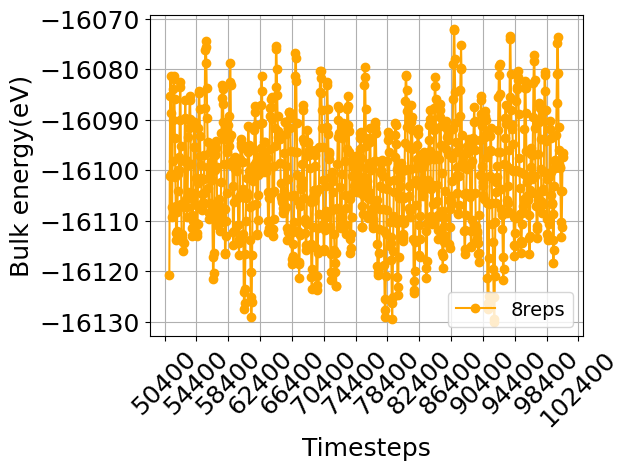

For the Bulk Energy:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Bulk Energy per atom is: [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per atom)
The Bulk Energy is (orange): [-3993.092815690117, -8029.99431505763, -12062.77247198676, -16101.256415140519] (in eV)


/tmp/ipykernel_4839/2101312617.py:194: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


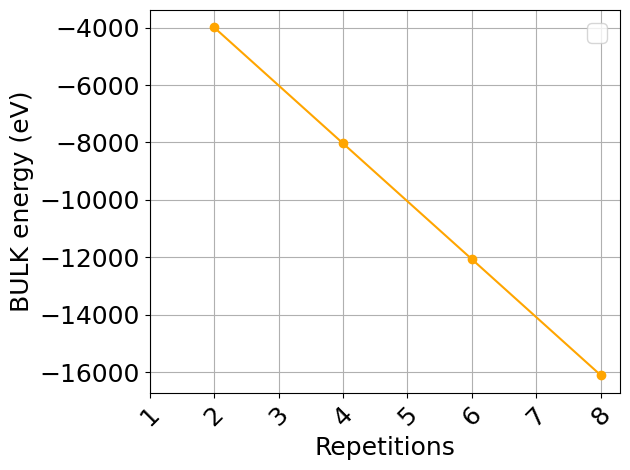

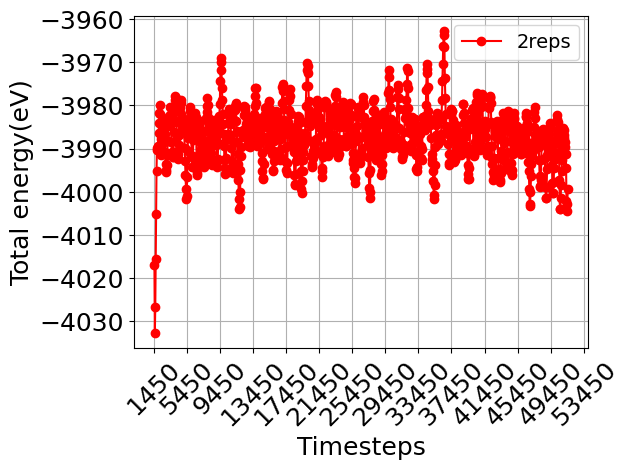

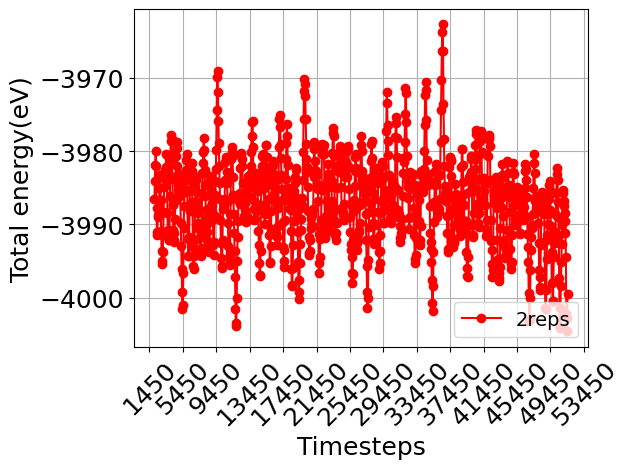

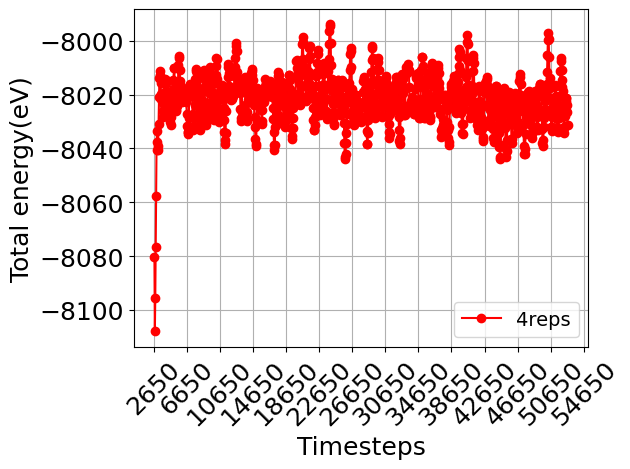

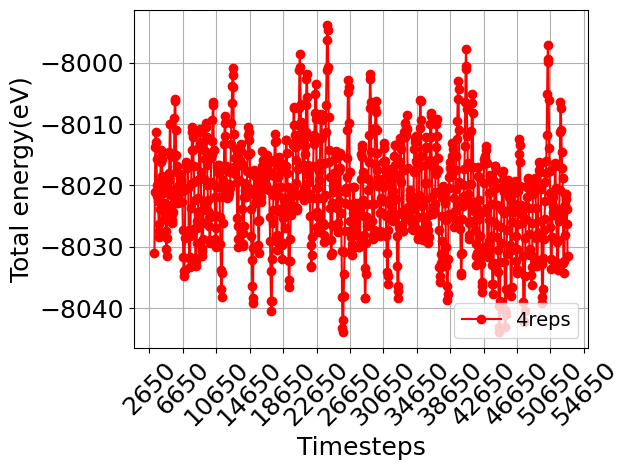

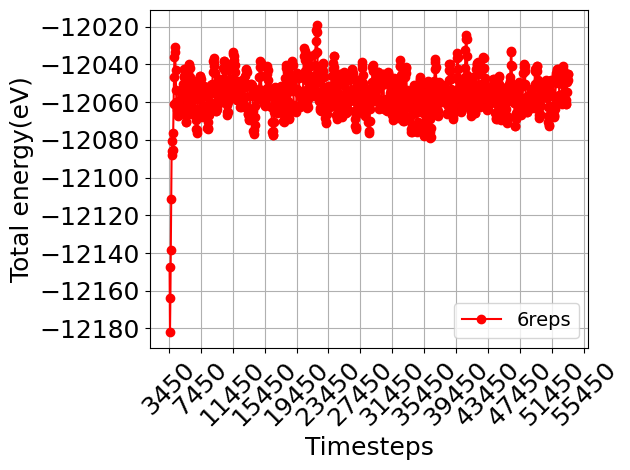

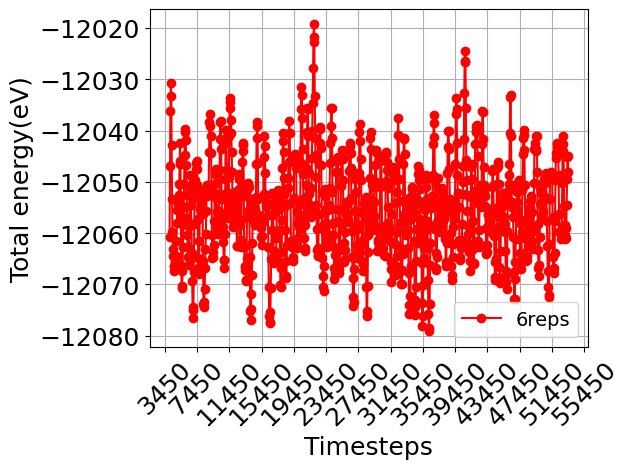

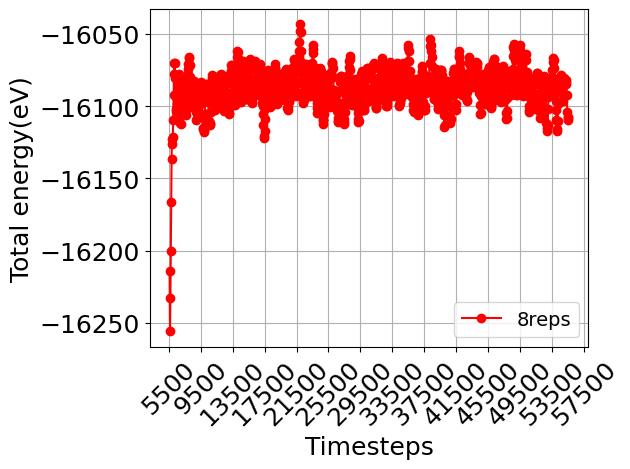

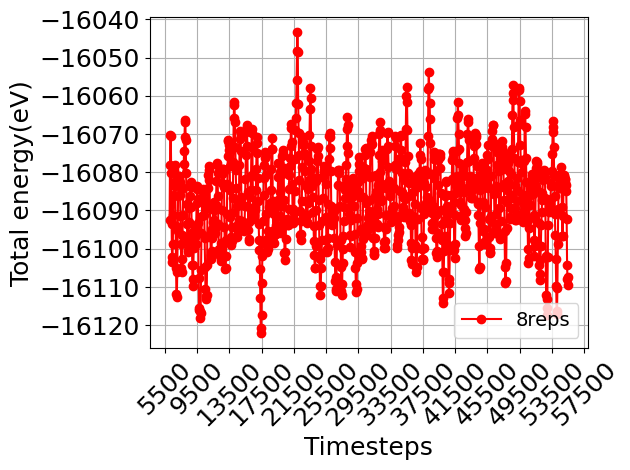


For the Total Energy of the GB:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Total Energy per atom is: [-3.485132929610037, -3.49364992251789, -3.4963047887588408, -3.4971866379869416] (in eV per atom)
The Total Energy is (red): [-3986.9920714738823, -8021.4202221010755, -12055.258911640483, -16087.058534739932] (in eV)


/tmp/ipykernel_4839/2101312617.py:395: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


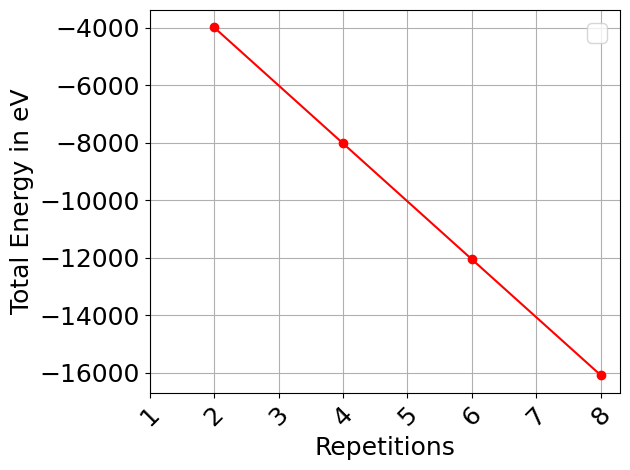


The Area of the GB is: 157.30529027915497 (in Å²)
The Area of the GB is: 161.61698071053635 (in Å²)

The Total Energies are (red): [-3986.9920714738823, -8021.4202221010755, -12055.258911640483, -16087.058534739932] (in eV)
The Bulk energies E_b are (orange): [-3993.092815690117, -8029.99431505763, -12062.77247198676, -16101.256415140519] (in eV)


/tmp/ipykernel_4839/2101312617.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


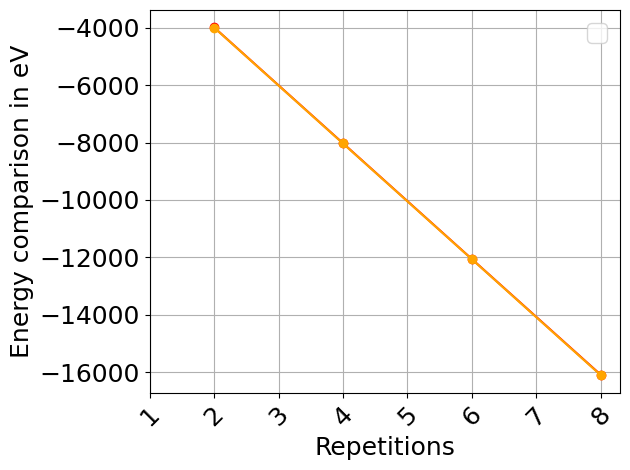


Testing:
The Total energies per atom are: [-3.485132929610037, -3.49364992251789, -3.4963047887588408, -3.4971866379869416]
The Bulk energies per Atom are: [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per Atom)
The Energy difference per Atom is: [0.005332818370834325, 0.003734361043795431, 0.0021791068289664928, 0.0030864957392582326] (in eV per Atom)
The Energy difference is: [6.100744216234467, 8.57409295655431, 7.513560346276467, 14.19788040058787] (in eV)
The Energy difference per Area of the GB is: [0.037748163524730045, 0.053051931293722876, 0.04648991902486787, 0.08784893974734588] (in eV/Å²)
The Energy difference per Area of the GB is: [0.6047935263605198, 0.8499874328017691, 0.7448521846326279, 1.407498142844026] (in J/m²)
The Energy difference is: [6.100744216234467, 8.57409295655431, 7.513560346276467, 14.19788040058787] (in eV)


/tmp/ipykernel_4839/2101312617.py:497: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


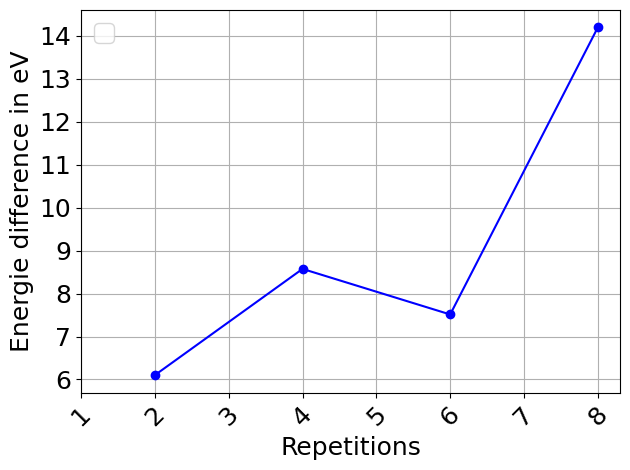



The Total energies per atom are (red): [-3.485132929610037, -3.49364992251789, -3.4963047887588408, -3.4971866379869416]
The Bulk energies per Atom are (orange): [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per Atom)


/tmp/ipykernel_4839/2101312617.py:520: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


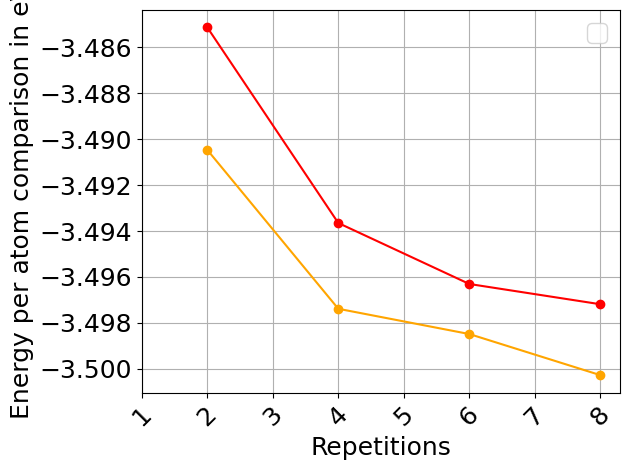

The Energy difference per Atom is: [0.005332818370834325, 0.003734361043795431, 0.0021791068289664928, 0.0030864957392582326] (in eV)


/tmp/ipykernel_4839/2101312617.py:540: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


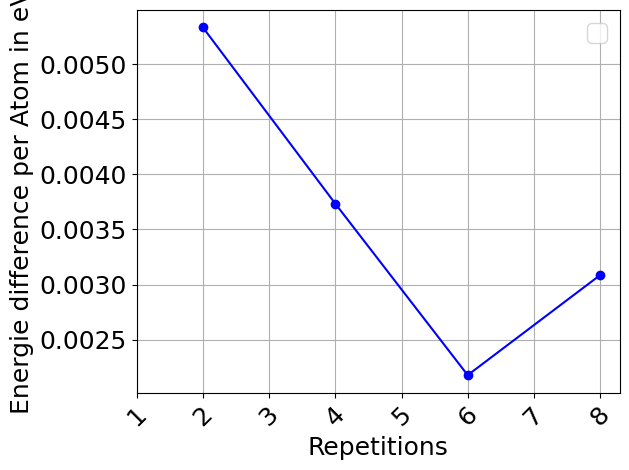



The formation energies are: [0.6047935263605219, 0.8499874328017902, 0.74485218463266, 1.407498142843906]


/tmp/ipykernel_4839/2101312617.py:564: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


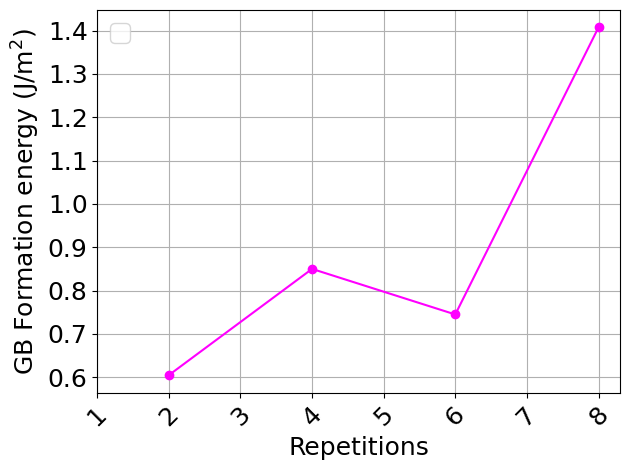


Timestamp:
01-04-2025 19:10


In [56]:
#1st Calculating the E_b Bulk_Energy of a Bulk (with 20Å Vacuum on both sides) that has been put through MD at 1000K

import csv

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Bulk_Energy = [] #needed later
Bulk_Energy_per_atom = [] #needed later
n_reps = [] #needed later
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    #MD_S9_mini_BULK is a bit of a misnomer (S9 should be removed) but if would have to change the folder creation skript 
    #maybe fix if this part becomes standard procedure
    base_file_path = f"{core_path}/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14-44-31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    #if rep_count == repeat[0]:
    #    print(f"Rep count is {rep_count}reps\n")
    #else:
    #    print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    #print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")


    # Step 4: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep_count}reps",color='orange')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Bulk energy(eV)",fontsize = 18)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()

    
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    

    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep_count}reps",color='orange')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()

    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    #print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Bulk_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Bulk_Energy_per_atom.append(Divided_Energy)
    #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")


# Step 9: print values for the Bulk Energy

print("For the Bulk Energy:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Bulk Energy per atom is: {Bulk_Energy_per_atom} (in eV per atom)")
print(f"The Bulk Energy is (orange): {Bulk_Energy} (in eV)")

# Step 10: plot BULK energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('BULK energy (eV)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/ref_Bulk_energy_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

#-------------------------------------------------- <--To Do: cleaner inclusion E_bulk calc


#2nd Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K with in 1 defined E_b

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Total_Energy = [] #needed later
Total_Energy_per_atom = [] #needed later
n_reps = [] #needed later

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    base_file_path = f"{core_path}/LAMMPS_Submision_006_19-03-2025_17-39-59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14-44-31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    #if rep_count == repeat[0]:
    #    print(f"Rep count is {rep_count}reps\n")
    #else:
    #    print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    #print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")

    # Step 4: plot the Energy over the Timesteps
       
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep_count}reps",color='red')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Total energy(eV)",fontsize = 18)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()

    
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")

    
    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep_count}reps",color='red')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    #print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Total_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Total_Energy_per_atom.append(Divided_Energy)
    #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
    

# Step 9: print values for the Total Energy of the GB

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

#plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_Energy_ver_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 10: calculate formation energy for each repetition

xAg = 0
A = 157.30529027915497
print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")
#kB = 1.380649*(10^(-23)) #in (m^2 kg s^-2 K^-1 or J K^-1)
#Mit Elektronenvolt (eV) als Energieeinheit hat die Boltzmann-Konstante den – ebenfalls exakten – Wert 8.617333262*(10^(-5)) (eV/K)
#kB = 8.617333262*(10**(-5))
#print(f"\nkB is: {kB}")
#note that Test = 10^(-5) #--> =-15!!! --> use Test = 10**(-5)
#temp_scaling_term = (kB*Temp)       #kB*T characteristic energy kBT associated with a single microscopic degree of freedom, (1DoF)
#                                    #where T denotes temperature and kB denotes the Boltzmann constant.


formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    formation_Energy.append(eform)                                                   

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

#plot comparison Total energy and Bulk energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()




#Testing:
#KEIN fehler in der Formel !!!
Bulk_Energy_per_Atom = []
Ediff = []
Ediff_per_area = []
Ediff_per_Atom = []
Ediff_per_area_inJ = []
for i in range(4):
    Bulk_Energy_per_Atom.append(Bulk_Energy[i]/n_reps[i])
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_Atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_Atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_Atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

#plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom}")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_Atom} (in eV per Atom)")

#plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_Atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_Atom} (in eV)")

#plot Ediff per atom over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_Atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()



print("\n")
print(f"The formation energies are: {formation_Energy}")


# Step 10: plot formation energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  009


Folder name for 009 is: LAMMPS_Submision_009_01-04-2025_17-50-00
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-2rep_10A_VACUUMS.data


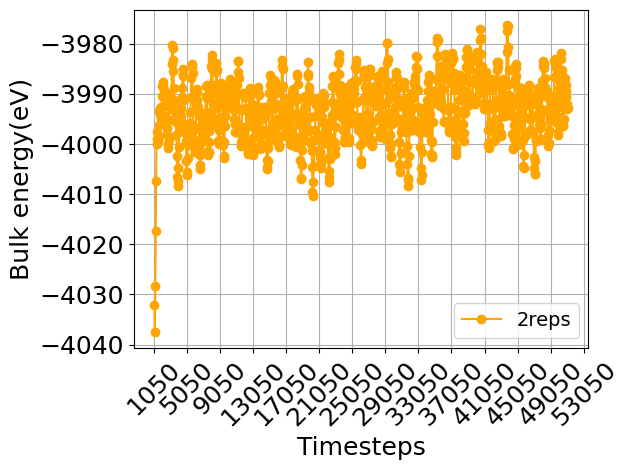

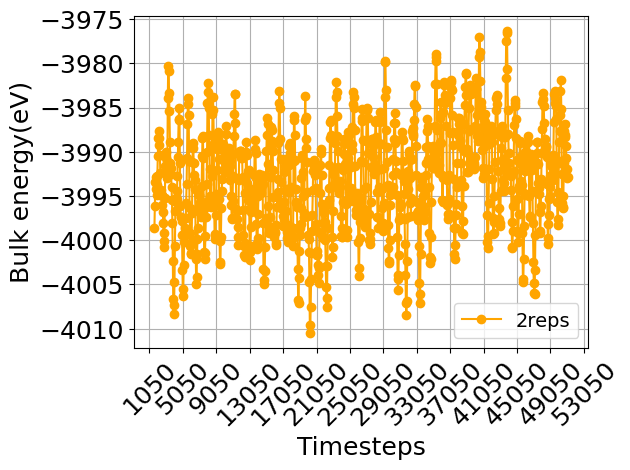

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-4rep_10A_VACUUMS.data


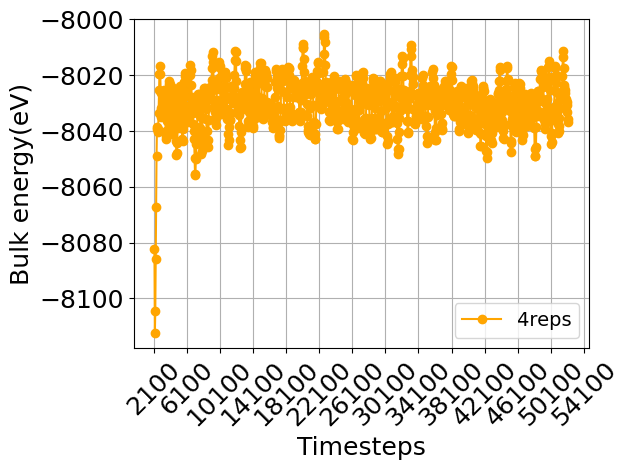

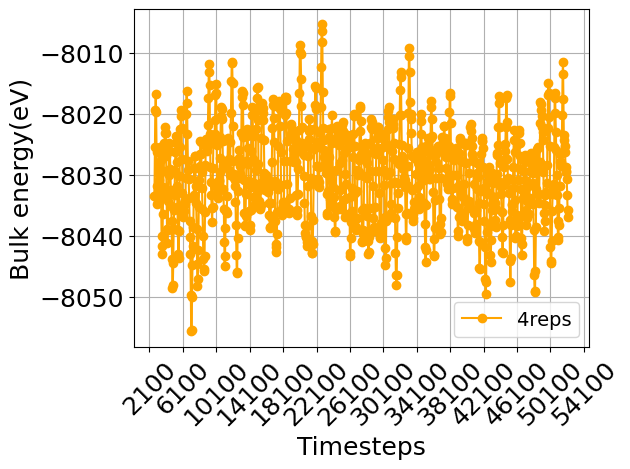

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-6rep_10A_VACUUMS.data


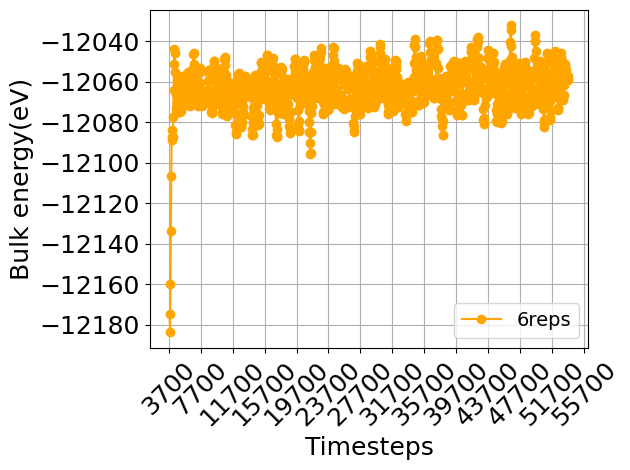

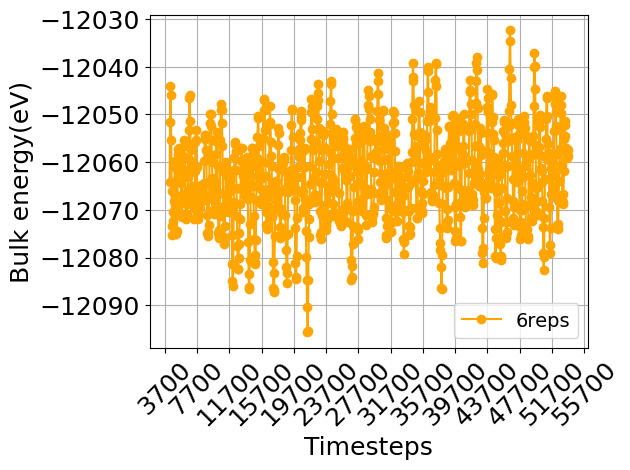

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-8rep_10A_VACUUMS.data


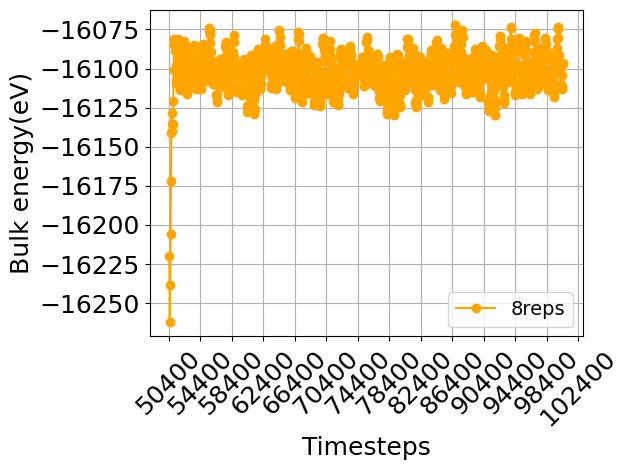

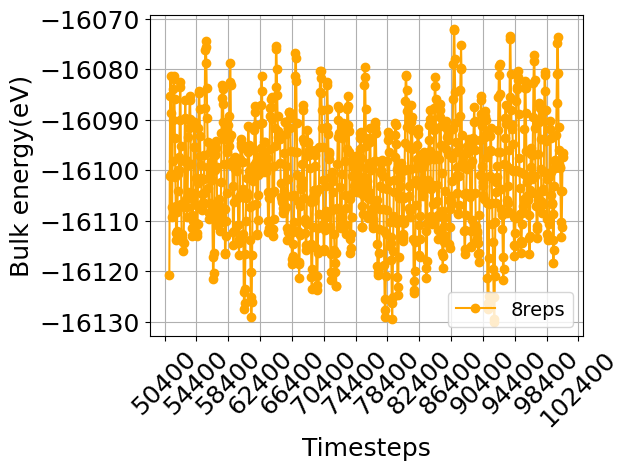

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data

Rep count is 2reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data/T_1000/thermo_data.csv


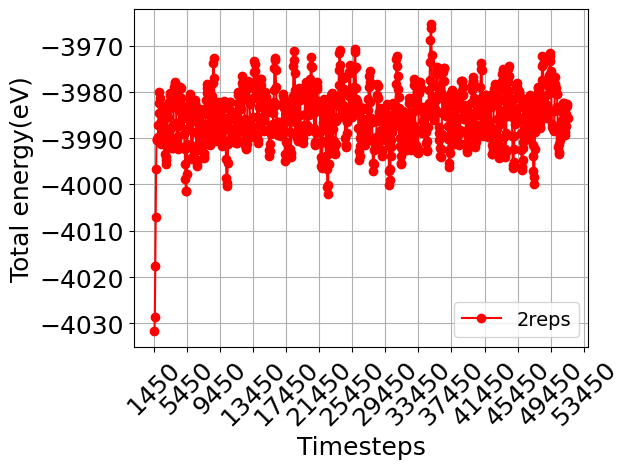

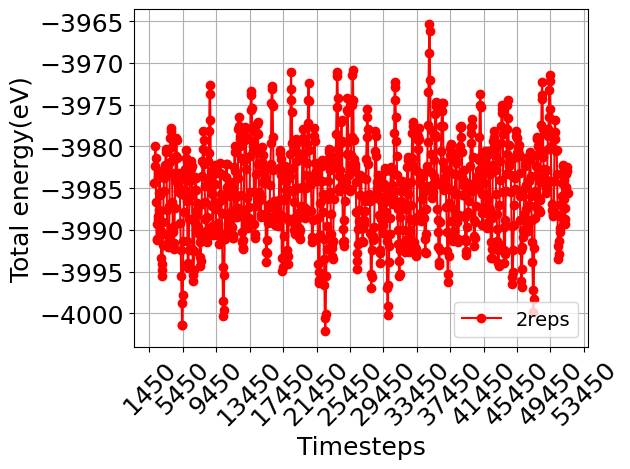

The average of the Energy is: -3985.44757185691 in eV
The Energy (per atom) is: -3.483782842532264 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data

Rep count is 4reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data/T_1000/thermo_data.csv


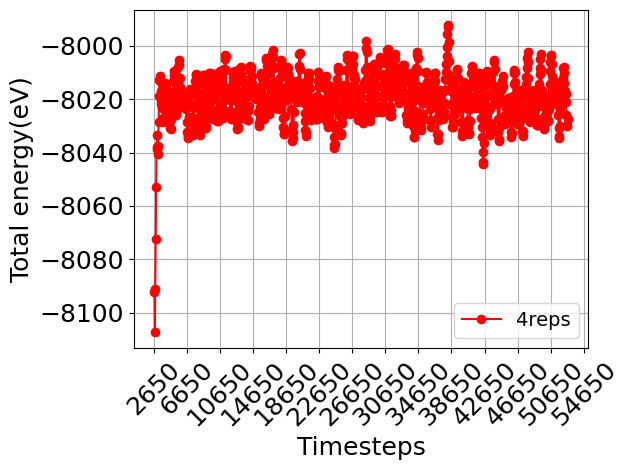

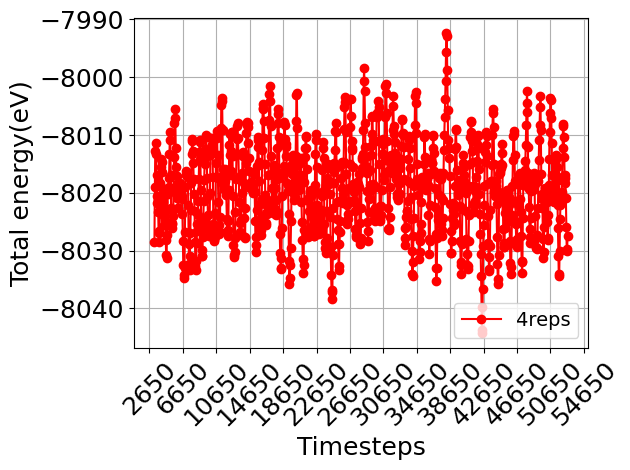

The average of the Energy is: -8019.181764198532 in eV
The Energy (per atom) is: -3.492674984407026 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data

Rep count is 6reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.csv


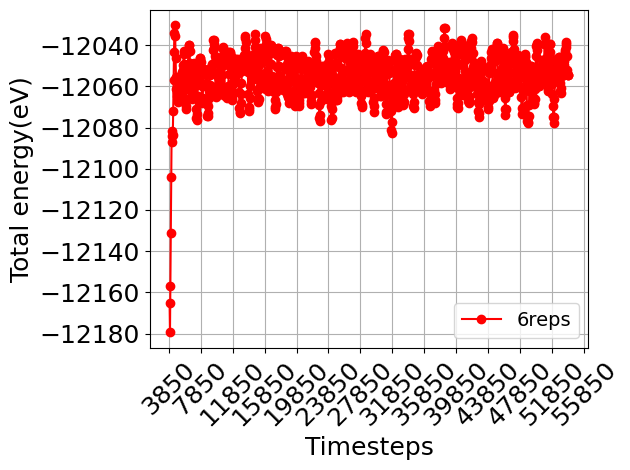

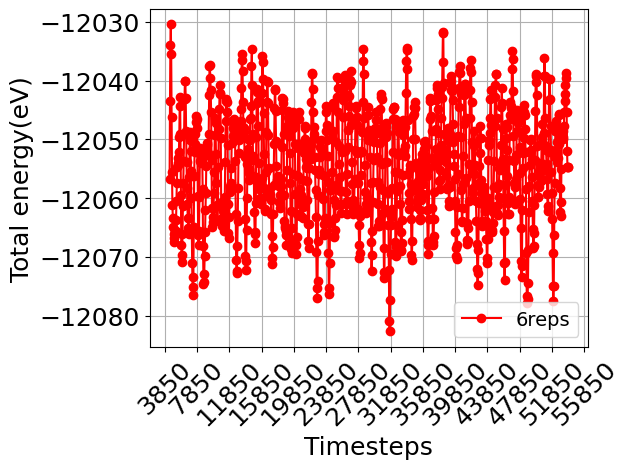

The average of the Energy is: -12054.647174116679 in eV
The Energy (per atom) is: -3.4961273706834914 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data

Rep count is 8reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data/T_1000/thermo_data.csv


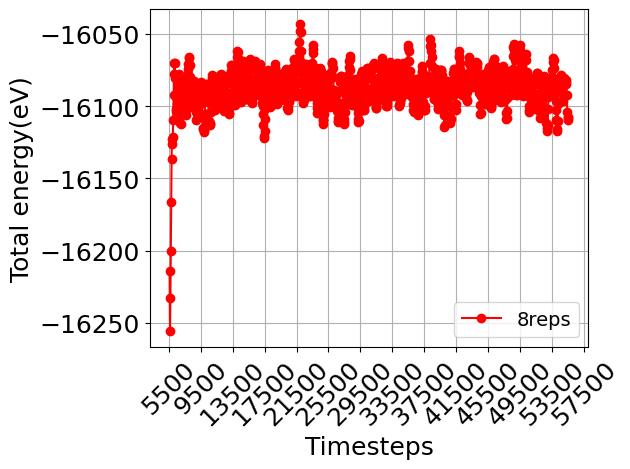

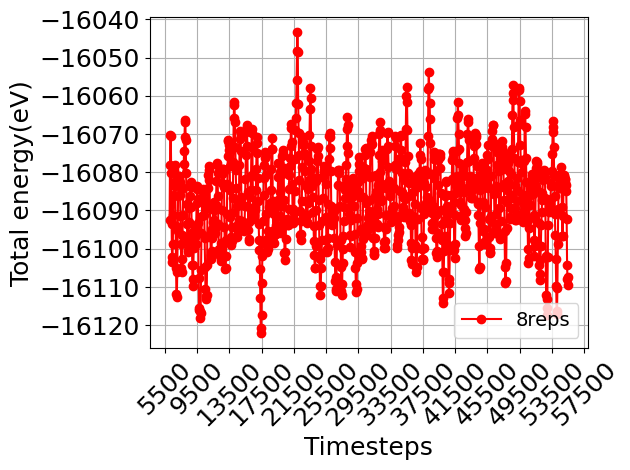

The average of the Energy is: -16087.058534739932 in eV
The Energy (per atom) is: -3.4971866379869416 in eV per atom
The Area of the GB is: 161.61698071053635 (in Å²)

For the Total Energy of the GB:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Total Energy per atom is: [-3.483782842532264, -3.492674984407026, -3.4961273706834914, -3.4971866379869416] (in eV per atom)
The Total Energy is (red): [-3985.44757185691, -8019.181764198532, -12054.647174116679, -16087.058534739932] (in eV)


/tmp/ipykernel_4839/3383048892.py:459: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


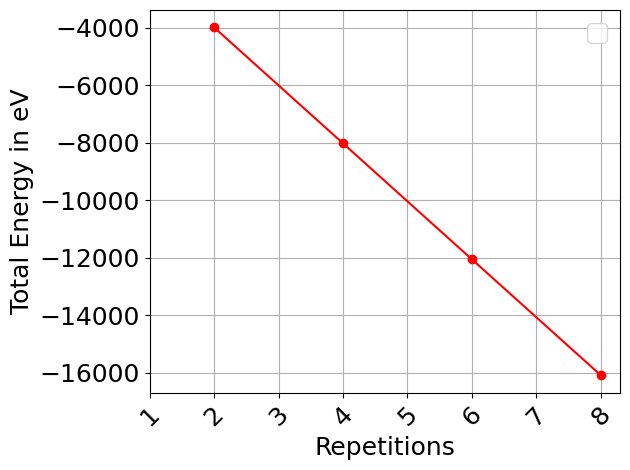

For the Bulk Energy:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Bulk Energy per atom is: [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per atom)
The Bulk Energy is (orange): [-3993.092815690117, -8029.99431505763, -12062.77247198676, -16101.256415140519] (in eV)


/tmp/ipykernel_4839/3383048892.py:485: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


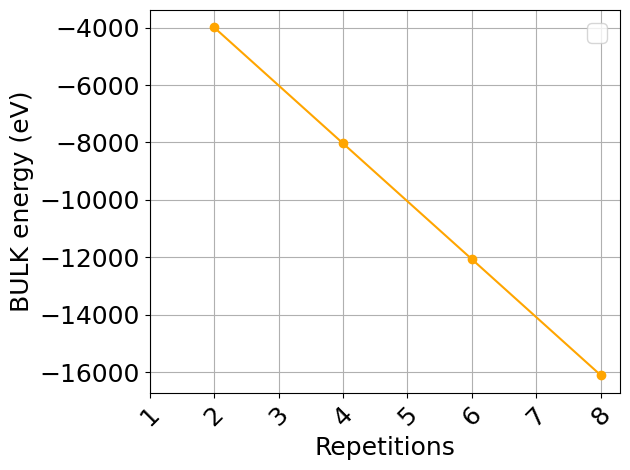


The Total Energies are (red): [-3985.44757185691, -8019.181764198532, -12054.647174116679, -16087.058534739932] (in eV)
The Bulk energies E_b are (orange): [-3993.092815690117, -8029.99431505763, -12062.77247198676, -16101.256415140519] (in eV)


/tmp/ipykernel_4839/3383048892.py:507: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


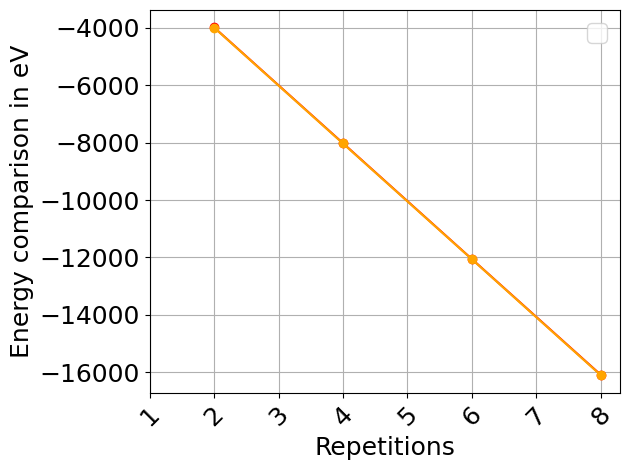


Testing:
The Total energies per atom are: [-3.483782842532264, -3.492674984407026, -3.4961273706834914, -3.4971866379869416]
The Bulk energies per Atom are: [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per Atom)
The Energy difference per Atom is: [0.006682905448607279, 0.004709299154659341, 0.0023565249043158154, 0.0030864957392582326] (in eV per Atom)
The Energy difference is: [7.645243833206727, 10.812550859097847, 8.125297870080932, 14.19788040058787] (in eV)
The Energy difference per Area of the GB is: [0.04730470647078676, 0.06690231936991593, 0.0502750257699327, 0.08784893974734588] (in eV/Å²)
The Energy difference per Area of the GB is: [0.7579065461336513, 1.071895580480919, 0.8054964078807078, 1.407498142844026] (in J/m²)
The Energy difference is: [7.645243833206727, 10.812550859097847, 8.125297870080932, 14.19788040058787] (in eV)


/tmp/ipykernel_4839/3383048892.py:556: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


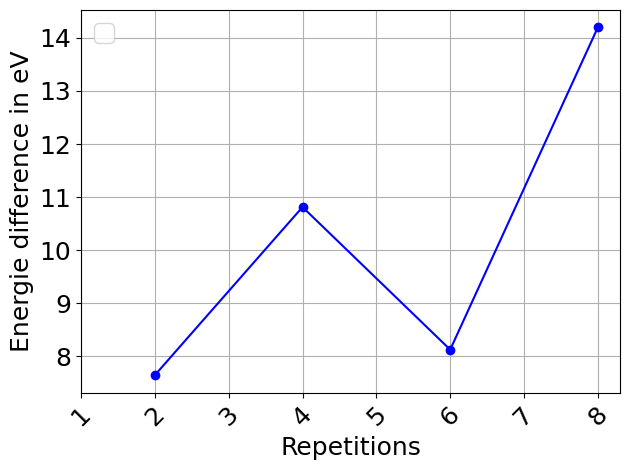



The Total energies per atom are (red): [-3.483782842532264, -3.492674984407026, -3.4961273706834914, -3.4971866379869416] (in eV per Atom)
The Bulk energies per Atom are (orange): [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per Atom)


/tmp/ipykernel_4839/3383048892.py:579: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


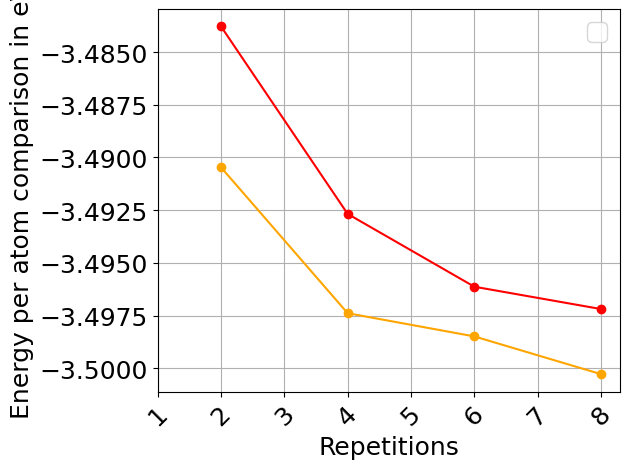

The Energy difference per Atom is: [0.006682905448607279, 0.004709299154659341, 0.0023565249043158154, 0.0030864957392582326] (in eV)


/tmp/ipykernel_4839/3383048892.py:600: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


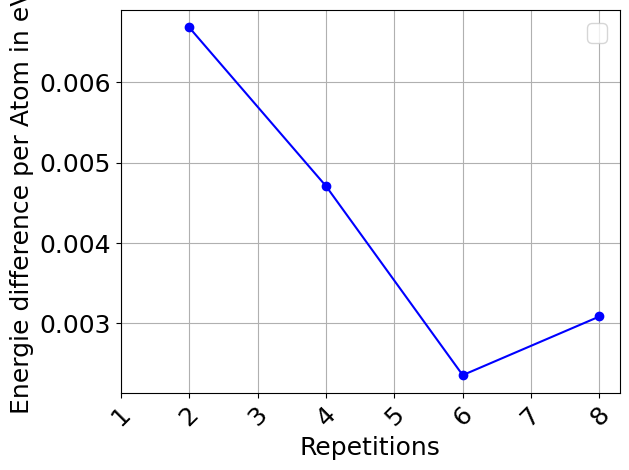



The formation energies are: [0.7579065461336463, 1.0718955804809678, 0.8054964078807482, 1.407498142843906]


/tmp/ipykernel_4839/3383048892.py:622: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


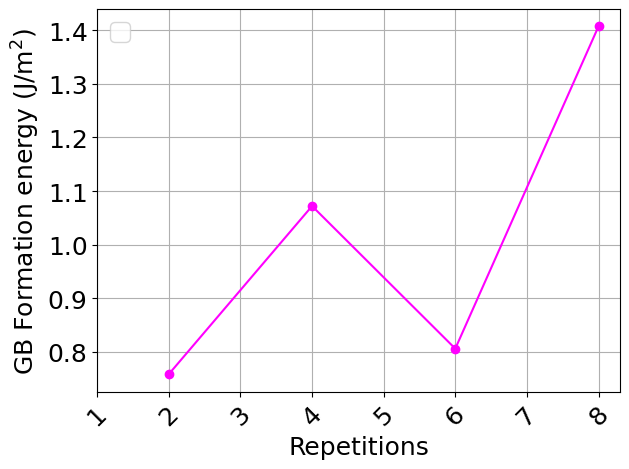


Timestamp:
01-04-2025 19:10


In [57]:
#UP to date 01_04_2025 REWORKED:

#All-in-one-systematic thermo-calc read:
#rewritten to ask for user input
#Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K 
#with E-B reference out of LAMMPS

# Ask the user for the LAMMPS index
#LAMMPS_index = '009'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables: (needs to be cleaned up)
# new
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

#carry over:
Formation_Energy = []

rep = []
bulk_rep = []
rep_count = []
repeat = []
bulk_repeat = []
n_reps = []

e_pot = []
e_bulk = []
Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# Path of the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

#WARNING,sorts by timestamp, not name!!!
#causes issue whe editing LAMMPS_Submision
for folder in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*"):
    # Get the parent directory of the file
    parent_folder = folder.parent
    #grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    #if "BULK" in grandparent_folder.name:
    if "BULK" in parent_folder.name:
        # If the folder does contain "BULK", process the file
     
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{bulk_rep}")
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found

        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file

        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        bulk_repeat.append(bulk_rep)
        #if rep_count == repeat[0]:
        #    print(f"Rep count is {rep_count}reps\n")
        #else:
        #    print(f"\nRep count is {rep_count}reps\n")
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        #print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")
    
        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
    
        # Step 2.4: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{bulk_rep}reps",color='orange')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="best")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Bulk energy(eV)",fontsize = 18)
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
    
        
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
    
        # Step 2.6: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{bulk_rep}reps",color='orange')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
    
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        #print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Bulk_Energy.append(averaged_Energy)
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Bulk_Energy_per_atom.append(Divided_Energy)
        #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

    else:
        # If the folder does not contain "BULK", process the file    
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{rep}")
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
            
        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
        
        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        repeat.append(rep)
        
        if rep_count == repeat[0]:
            print(f"Rep count is {rep}reps\n")
        else:
            print(f"\nRep count is {rep}reps\n")
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")
    
        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
        
        # Step 2.4: plot the Energy over the Timesteps
            
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Total energy(eV)",fontsize = 18)
        plt.tight_layout()
    
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
           
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
        
        # Step 2.6: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
        
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Total_Energy.append(averaged_Energy)
        n_reps.append(len(atoms2))
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

"""
#sort:
#print(repeat)
repeat = sorted(repeat)
#print(repeat)
#print(n_reps)
n_reps = sorted(n_reps)
#print(n_reps)
#print(Bulk_Energy)
Bulk_Energy = sorted(Bulk_Energy, reverse = True)
#print(Bulk_Energy)
Total_Energy = sorted(Total_Energy, reverse = True)
"""
               
# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_Energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 9: print values for the Bulk Energy

print("For the Bulk Energy:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Bulk Energy per atom is: {Bulk_Energy_per_atom} (in eV per atom)")
print(f"The Bulk Energy is (orange): {Bulk_Energy} (in eV)")

# Step 10: plot BULK energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('BULK energy (eV)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/ref_Bulk_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

#for i in range(4):
#    Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Step 11: plot formation energy over repetitions of the supercell:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:









#GB opt1 energy over distance read:

#OPEN OPEN OPEN OPEN OPEN!!!!!!!!!!!!!!!!








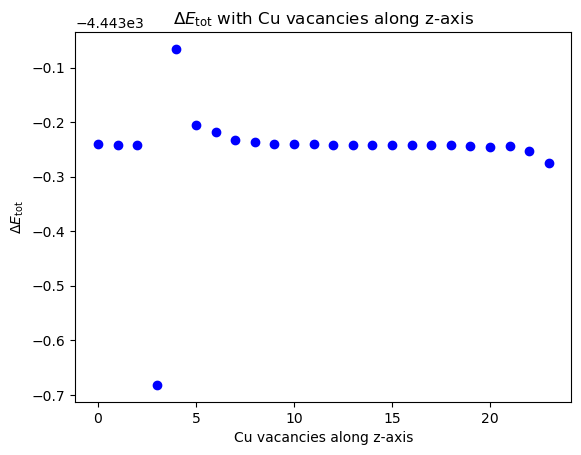

In [1]:
#18 Sigma3_Cu #by melissa

# Plots the calculated total energies for each vacancy position against the z-coordinates of the Cu vacancies 
# to observe how the energy changes as a function of the Cu atom's position along the z-axis.
# Note that the plot below is not in the correct sequence, so the code has to be modfied.

# dummy plot
import matplotlib.pyplot as plt
import numpy as np

# Dummy data
#cu_z_coordinates = np.array([0, 1, 2, 3, 4, 5])
#defect_energy = np.array([0.1, -0.2, -0.15, 0.05, -0.05, 0.0])

cu_z_coordinates = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
defect_energy = np.array([-4443.240778640902, -4443.240943169932, -4443.240972387624, -4443.681879930195, -4443.065464147459, -4443.204156706558, -4443.218077006707, -4443.233197668452, -4443.236809455697, -4443.239119715825, -4443.239947904565, -4443.240554636743, -4443.240902827747, -4443.240985693614, -4443.2410008636325, -4443.241046854947, -4443.241142594003, -4443.241204899594, -4443.241405299071, -4443.24267008543, -4443.245454434203, -4443.2442943957885, -4443.253397693497, -4443.274348771868])


plt.scatter(cu_z_coordinates, defect_energy, color='blue')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancies along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


In [ ]:
#18 Sigma3_Cu #by melissa

# Save cu_x_coordinates, cu_y_coordinates, cu_z_coordinates, and Defect_energy to a text file.

with open('defect_data_Cu_sigma3_xyz_all_ordered_simplified.txt', 'w') as file:
    file.write('x-coordinate, y-coordinate, z-coordinate, Defect Energy\n')
    for x, y, z, energy in zip(cu_x_coordinates, cu_y_coordinates, cu_z_coordinates, defect_energy):
        file.write(f'{x}, {y}, {z}, {energy}\n')

print('Data saved to defect_data_Cu_sigma3_xyz_all_ordered_simplified.txt')

In [ ]:
#18 Sigma3_Cu #by melissa

# Calculates and plots the difference between Minimum Formation Energy and Formation Energy that was calculated in cell [11].
# The sequence here is also not in order. The data from the plot hereis also saved in a text file. 
# Be aware of the names of the two text files being saved.

min_energy = min(defect_energy)
energy_diff = [energy - min_energy for energy in defect_energy]

print("DONE")

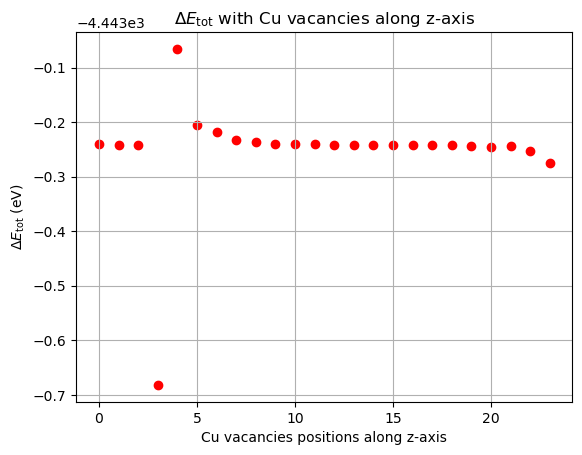

In [2]:
#18 Sigma3_Cu #by melissa
# dummy plot
import matplotlib.pyplot as plt
import numpy as np

# Dummy data
cu_z_coordinates = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
energy_diff = np.array([-4443.240778640902, -4443.240943169932, -4443.240972387624, -4443.681879930195, -4443.065464147459, -4443.204156706558, -4443.218077006707, -4443.233197668452, -4443.236809455697, -4443.239119715825, -4443.239947904565, -4443.240554636743, -4443.240902827747, -4443.240985693614, -4443.2410008636325, -4443.241046854947, -4443.241142594003, -4443.241204899594, -4443.241405299071, -4443.24267008543, -4443.245454434203, -4443.2442943957885, -4443.253397693497, -4443.274348771868])

# Plot
plt.scatter(cu_z_coordinates, energy_diff, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
#plt.xlabel('Cu vacancies along z-axis')
plt.xlabel('Cu vacancies positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)
plt.show()

In [ ]:
#18 Sigma3_Cu #by melissa

# Uncommented

with open('defect_data_CuGaSe2_sigma3_energy_difference_vs_z.txt', 'w') as file:
    file.write('z-coordinate, Energy - min. energy\n')
    for z, energy_diff in zip(cu_z_coordinates, energy_diff):
        file.write(f'{z}, {energy_diff}\n')

print('Data saved to defect_data_CuGaSe2_sigma3_energy_difference_vs_z.txt')

In [ ]:
import re
from pathlib import Path
from ase.io import read

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
    folder_name = grandparent_folder.name.lower()
    file_name = f.name.lower()

    # Check if the file is tagged with Vac or Ag
    if "vac" in file_name or "ag" in file_name:
        vac_or_ag = True
    else:
        vac_or_ag = False

    # === BULK PATH ===
    if "bulk" in folder_name:
        print(f"BULK folder: {grandparent_folder} (Vac/Ag: {vac_or_ag})")
        match = re.search(r'(\d+)rep.*\.data$', grandparent_folder.name)
        if match:
            bulk_rep = int(match.group(1))
        else:
            print("Skipping: No repetition found")
            continue

        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        e_bulk_uncorrected = atoms1.get_potential_energy()
        e_bulk = Corrected_Energy(e_bulk_uncorrected, atoms1)

        Bulk_Energy.append(e_bulk)
        Divided_Energy = e_bulk / len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        print(f"{bulk_rep} reps done\n")
        bulk_repeat.append(bulk_rep)

    # === GB PATH ===
    elif "gb" in folder_name:
        print(f"GB folder: {grandparent_folder} (Vac/Ag: {vac_or_ag})")
        match = re.search(r'(\d+)rep.*\.data$', grandparent_folder.name)
        if match:
            rep = int(match.group(1))
        else:
            print("Skipping: No repetition found")
            continue

        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)

        Total_Energy.append(e_pot)
        Divided_Energy = e_pot / len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"{rep} reps done\n")
        repeat.append(rep)

    else:
        print(f"Skipping (Not BULK or GB): {grandparent_folder}")

In [ ]:
#To do

from collections import defaultdict
import re


# Ask the user for the LAMMPS index
LAMMPS_index = '011'
#LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#Section 1 read out energies from incl/Vac <----------------------------------------DONE NEEDS POLISH

incl = "Ag"

# Define the base directory
project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
base_dir = f"{project_dir}/data/LAMMPS_Data"

# Clear preexisting variables
layer = []
layers = []
e_pot_Vac = []
Total_Energy_Vac = []
Total_Energy_Vac_per_atom = []
e_pot_incl = []
Total_Energy_incl = []
Total_Energy_incl_per_atom = []
e_pot_ref = []
Total_Energy_ref = []
Total_Energy_ref_per_atom = []
n_reps = []

"""
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []
"""

# List all directories in the base directory
base_path = Path(base_dir)


# Initialize dictionaries to store energies for both Vac and incl
vac_energies_dict = defaultdict(list)
incl_energies_dict = defaultdict(list)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        #match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        """
        Explanation:
        (\d+)z-layers: Captures the number before z-layers.
        .*?: Lazily matches anything between z-layers and PosXX.
        (Pos\d+)?: Optionally matches and captures PosXX.
        \.data$: Ensures it ends with .data.
        """
        #match2 = re.search(r'(\d+)z-layers.*?(Pos\d+)?\.data$', data_folder.name)
        #match2 = re.search(r'(\d+)z-layers.*?(Pos\d+-Vac)?\.data$', data_folder.name)
        #goal: 0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data
        #problem: 0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data also matched
        #fixed: r'(\d+)z-layers.*?Pos\d+-Vac\.mini\.data$'

        #old ver:
        #matchVac = re.search(r'(\d+)z-layers.*?Pos\d+-Vac\.mini\.data$', data_folder.name)
        matchVac = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder.name)
        """
        Explanation:
        Ensures Pos\d+-Vac is required.
        Matches the .mini.data suffix exactly, not just .data.
        Avoids accidentally matching similar patterns like -Ag.
        """         
        
        if matchVac:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_Vac_str)
            position = matchVac.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_Vac_uncorrected = atoms1.get_potential_energy()
            e_pot_Vac = Corrected_Energy(e_pot_Vac_uncorrected, atoms1)
            # Add to the vac_energies dictionary
            vac_energies_dict[position].append(e_pot_Vac)
            print("Supercell potential Energy:")
            print(e_pot_Vac, "eV")
            Total_Energy_Vac.append(e_pot_Vac)
        
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_Vac
            print(f"Undivided_Energy{Undivided_Energy}")
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_Vac_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl:
            layers_incl_str = matchincl.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_incl_str)
            position = matchincl.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_incl_uncorrected = atoms1.get_potential_energy()
            e_pot_incl = Corrected_Energy(e_pot_incl_uncorrected, atoms1)
            # Add to the incl_energies dictionary
            incl_energies_dict[position].append(e_pot_incl)

            print("Supercell potential Energy:")
            print(e_pot_incl, "eV")
            Total_Energy_incl.append(e_pot_incl)
            
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_incl
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_incl_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        """
        # Global variable
        incl = "Vac"  # You can change this to "Ag" or anything else, or even leave it dynamic

        # Constructing the regex pattern dynamically using the global variable
        pattern = re.compile(r'(\d+)z-layers(?!.*Pos\d+-(Vac|Ag))\.mini\.data$')

        # Test filenames
        filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"
        filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        filename3 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data"  # Should match
        filename4 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Other.mini.data"  # Should match

        print(bool(pattern.search(filename1)))  # ❌ False (excluded due to -Vac)
        print(bool(pattern.search(filename2)))  # ❌ False (excluded due to -Ag)
        print(bool(pattern.search(filename3)))  # ✅ True (no PosXX)
        print(bool(pattern.search(filename4)))  # ✅ True (no -Vac or -Ag)
        """

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder

        """
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #matchref = re.search(r'(\d+)z-layers.*?Pos\d+-Vac\.mini\.data$', data_folder.name)
        matchref = re.search(r'0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data', data_folder.name) #temp solution
        
        if matchref:
            layers_ref_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_ref_str)
            print(f"Confirm file: {f.name}")

            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_ref_uncorrected = atoms1.get_potential_energy()
            e_pot_ref = Corrected_Energy(e_pot_ref_uncorrected, atoms1)
            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)
        
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_ref
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_ref_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer) 
            
            print("ref DONE\n")

        else:
            print(f"No Ref in folder name found")
            #continue  # Skip if no layer count is found
        """

        # Replace with the actual path or folder object if needed
        data_folder_name = data_folder.name  # Assumes data_folder is a pathlib.Path or similar object

        # Exact match with folder name
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error

            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name}")

            
            GB = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms1.set_calculator(pot)

            n_reps.append(len(atoms1))

            e_pot_ref_uncorrected = atoms1.get_potential_energy()
            e_pot_ref = Corrected_Energy(e_pot_ref_uncorrected, atoms1)

            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)

            Undivided_Energy = e_pot_ref
            Divided_Energy = Undivided_Energy / len(atoms1)
            Total_Energy_ref_per_atom.append(Divided_Energy)
        
            print(f"The Energy (per atom) is: {Divided_Energy} eV per atom")

            if layers:
                print(f"{layers} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------





"""
# Initialize dictionaries to store energies for both Vac and incl
vac_energies = defaultdict(list)
incl_energies = defaultdict(list)

# Loop through your data files
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
    # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue  # Skip BULK files
    else:
"""

"""
#new:
# Sorting the dictionary by position (keys)
sorted_vac_energies = sorted(vac_energies.items())
sorted_incl_energies = sorted(incl_energies.items())

# Print out the sorted energies with their positions
print("Vacancy Energies (Sorted by Position):")
for pos, energies in sorted_vac_energies:
    print(f"Pos{pos}: {energies}")

print("\nInclination Energies (Sorted by Position):")
for pos, energies in sorted_incl_energies:
    print(f"Pos{pos}: {energies}")
"""

print("\n")
print(f"vac_energies_dict:\n{vac_energies_dict}\n") 
print(f"incl_energies_dict:\n{incl_energies_dict}\n") 


"""
# Sorting the dictionary by the numerical value of position
sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0][3:]))  # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0][3:]))  # Extract number from "PosXX"
"""

# Sorting the dictionary by position (keys)
#sorted_vac_energies_dict = sorted(vac_energies_dict.items())
#sorted_incl_energies_dict = sorted(incl_energies_dict.items())

sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

"""
sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0][3:])) # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0][3:])) # Extract number from "PosXX"
"""

"""
Explanation:

    Sorting by numeric position: The key for sorting is lambda x: int(x[0][3:]),
    which takes the PosXX string and slices it to get the numeric part (i.e., x[0][3:] gives XX from PosXX). 
    It then converts that part to an integer for proper numeric sorting.

    Example:

        Pos1 will be sorted as 1
        Pos2 will be sorted as 2
        Pos10 will be sorted as 10

Now the dictionary will be sorted correctly by numeric position.
"""
sorted_positions = []
sorted_Total_Energy_Vac = []
sorted_Total_Energy_incl = []

# Print out the sorted energies with their positions
print("\nVacancy Energies (Sorted by Position):")
for pos, energies in sorted_vac_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_Vac.append(energies[0])  #Extract the energy float value
    sorted_positions.append(pos)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos, energies in sorted_incl_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_incl.append(energies[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict:\n{sorted_vac_energies_dict}\n") 
print(f"sorted_incl_energies_dict:\n{sorted_incl_energies_dict}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac:{Total_Energy_Vac};\n{len(Total_Energy_Vac)} Total_Energy_Vac list entrys")
print(f"Total_Energy_incl:{Total_Energy_incl};\n{len(Total_Energy_incl)} Total_Energy_incl list entrys")


print("\n")
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value

#Quick plot:
print("sorted_Total_Energy_Vac plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()










# Step 3:  Calculate Enegy Delta:
"""
#calculate delta: [Total_Energy_incl[index]]-[Total_Energy_ref]]

#Energy Delta for all 24 pos Ag
Energy_Delta_incl = []

#calculate delta: [Total_Energy_Vac[index]]-[Total_Energy_ref]]
#Energy Delta for all 24 pos Vac
Energy_Delta_Vac = []
"""

# Assuming Total_Energy_ref has only one value
ref_energy = Total_Energy_ref[0]

# Calculate delta lists
Energy_Delta_incl = [energy - ref_energy for energy in Total_Energy_incl]
Energy_Delta_Vac = [energy - ref_energy for energy in Total_Energy_Vac]

# Optional: print for confirmation
print(f"Energy_Delta_incl: {Energy_Delta_incl};\n{len(Energy_Delta_incl)} Energy_Delta_incl list entrys")
print(f"Energy_Delta_Vac: {Energy_Delta_Vac};\n{len(Energy_Delta_Vac)} Energy_Delta_Vac list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------OPEN

#EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

#Step 1: Find positions:


# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB)
#reminder no screen elemnts outside of the office possible
#GB.edit()



# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
"""
print(GB_revert)
GB.edit()
"""

# Step 8.1 find center
center = find_center_of_atoms(GB)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
ask_to_check_visuals = "skip"

GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""
distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
print(f"distance_to_center_index_list = {distance_to_center_index_list}")

#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

print(f"index list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")


# Assuming you have an ASE Atoms object named atoms (replace with your actual Atoms object)
# Example of an Atoms object (Replace with your actual object)
# atoms = Atoms(...)

# Your list of indices
# distance_to_center_index_list = [271, 53, 69, 74, 77, 104, 107, 111, 112, 115, 116, 119, 123, 127, 154, 162, 168, 184, 194, 201]

# Extract z-positions of atoms at the given indices
z_positions = [GB[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions = sorted(z_positions)

# Print the sorted z-positions
print(f"sorted_z_positions:\n {sorted_z_positions}")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions = [z - closest_atom_position[2] for z in sorted_z_positions]
print(f"\ndelta_z_positions:\n {delta_z_positions};\n{len(delta_z_positions)} delta_z_positions list entrys")

#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

#do both:



#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

#Pos Delta for all 24 pos Ag
Pos_Delta_incl = []

#Pos Delta for all 24 pos Vac
Pos_Delta_vac = []

#EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

#Section 3 plot <-----------------------------------------------------------------OPEN

"""
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#plot E_Delta over d_Delta

print("Segregation Energies over d_Delta")

plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
plt.grid(False)
plt.legend(fontsize=18, loc="best")
plt.xticks(rotation=45)
plt.xticks(fontsize=18)
plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
plt.ylabel('GB Formation energy (J/m$^2$)', fontsize=18)
plt.yticks(fontsize=18)
# Optional dynamic ticks again
# plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
plt.tight_layout()






#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# Plot dots blue
plt.scatter(cu_z_coordinates, defect_energy, color='blue')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancies along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()



#18 Sigma3_Cu #by melissa

# Plots the calculated total energies for each vacancy position against the z-coordinates of the Cu vacancies 
# to observe how the energy changes as a function of the Cu atom's position along the z-axis.
# Note that the plot below is not in the correct sequence, so the code has to be modfied.

# dummy plot
import matplotlib.pyplot as plt
import numpy as np

# Dummy data
#cu_z_coordinates = np.array([0, 1, 2, 3, 4, 5])
#defect_energy = np.array([0.1, -0.2, -0.15, 0.05, -0.05, 0.0])

cu_z_coordinates = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
defect_energy = np.array([-4443.240778640902, -4443.240943169932, -4443.240972387624, -4443.681879930195, -4443.065464147459, -4443.204156706558, -4443.218077006707, -4443.233197668452, -4443.236809455697, -4443.239119715825, -4443.239947904565, -4443.240554636743, -4443.240902827747, -4443.240985693614, -4443.2410008636325, -4443.241046854947, -4443.241142594003, -4443.241204899594, -4443.241405299071, -4443.24267008543, -4443.245454434203, -4443.2442943957885, -4443.253397693497, -4443.274348771868])


plt.scatter(cu_z_coordinates, defect_energy, color='blue')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancies along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#-------------------------------------------------------
# Plot dots red 
plt.scatter(cu_z_coordinates, energy_diff, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancies along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)
plt.show()



#18 Sigma3_Cu #by melissa
# dummy plot
import matplotlib.pyplot as plt
import numpy as np

# Dummy data
cu_z_coordinates = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
energy_diff = np.array([-4443.240778640902, -4443.240943169932, -4443.240972387624, -4443.681879930195, -4443.065464147459, -4443.204156706558, -4443.218077006707, -4443.233197668452, -4443.236809455697, -4443.239119715825, -4443.239947904565, -4443.240554636743, -4443.240902827747, -4443.240985693614, -4443.2410008636325, -4443.241046854947, -4443.241142594003, -4443.241204899594, -4443.241405299071, -4443.24267008543, -4443.245454434203, -4443.2442943957885, -4443.253397693497, -4443.274348771868])

# Plot
plt.scatter(cu_z_coordinates, energy_diff, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
#plt.xlabel('Cu vacancies along z-axis')
plt.xlabel('Cu vacancies positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)
plt.show()
#------------------------------------------------------- 





#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
"""

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [1]:
#To do

from collections import defaultdict
import re


# Ask the user for the LAMMPS index
LAMMPS_index = '011'
#LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#Section 1 read out energies from incl/Vac <----------------------------------------DONE NEEDS POLISH

incl = "Ag"

# Define the base directory
project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
base_dir = f"{project_dir}/data/LAMMPS_Data"

# Clear preexisting variables
layer = []
layers = []
e_pot_Vac = []
Total_Energy_Vac = []
Total_Energy_Vac_per_atom = []
e_pot_incl = []
Total_Energy_incl = []
Total_Energy_incl_per_atom = []
e_pot_ref = []
Total_Energy_ref = []
Total_Energy_ref_per_atom = []
n_reps = []

"""
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []
"""

# List all directories in the base directory
base_path = Path(base_dir)


# Initialize dictionaries to store energies for both Vac and incl
vac_energies_dict = defaultdict(list)
incl_energies_dict = defaultdict(list)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        print(Path(grandparent_folder))
        data_folder = grandparent_folder

        matchVac = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder.name)
        
        if matchVac:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_Vac_str)
            position = matchVac.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_Vac_uncorrected = atoms1.get_potential_energy()
            e_pot_Vac = Corrected_Energy(e_pot_Vac_uncorrected, atoms1)
            # Add to the vac_energies dictionary
            vac_energies_dict[position].append(e_pot_Vac)
            print("Supercell potential Energy:")
            print(e_pot_Vac, "eV")
            Total_Energy_Vac.append(e_pot_Vac)
        
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_Vac
            print(f"Undivided_Energy{Undivided_Energy}")
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_Vac_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl:
            layers_incl_str = matchincl.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_incl_str)
            position = matchincl.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_incl_uncorrected = atoms1.get_potential_energy()
            e_pot_incl = Corrected_Energy(e_pot_incl_uncorrected, atoms1)
            # Add to the incl_energies dictionary
            incl_energies_dict[position].append(e_pot_incl)

            print("Supercell potential Energy:")
            print(e_pot_incl, "eV")
            Total_Energy_incl.append(e_pot_incl)
            
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_incl
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_incl_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        # Replace with the actual path or folder object if needed
        data_folder_name = data_folder.name  # Assumes data_folder is a pathlib.Path or similar object

        # Exact match with folder name
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error

            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name}")

            
            GB = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms1.set_calculator(pot)

            n_reps.append(len(atoms1))

            e_pot_ref_uncorrected = atoms1.get_potential_energy()
            e_pot_ref = Corrected_Energy(e_pot_ref_uncorrected, atoms1)

            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)

            Undivided_Energy = e_pot_ref
            Divided_Energy = Undivided_Energy / len(atoms1)
            Total_Energy_ref_per_atom.append(Divided_Energy)
        
            print(f"The Energy (per atom) is: {Divided_Energy} eV per atom")

            if layers:
                print(f"{layers} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------


print("\n")
print(f"vac_energies_dict:\n{vac_energies_dict}\n") 
print(f"incl_energies_dict:\n{incl_energies_dict}\n") 

sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

sorted_positions = []
sorted_Total_Energy_Vac = []
sorted_Total_Energy_incl = []

# Print out the sorted energies with their positions
print("\nVacancy Energies (Sorted by Position):")
for pos, energies in sorted_vac_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_Vac.append(energies[0])  #Extract the energy float value
    sorted_positions.append(pos)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos, energies in sorted_incl_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_incl.append(energies[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict:\n{sorted_vac_energies_dict}\n") 
print(f"sorted_incl_energies_dict:\n{sorted_incl_energies_dict}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac:{Total_Energy_Vac};\n{len(Total_Energy_Vac)} Total_Energy_Vac list entrys")
print(f"Total_Energy_incl:{Total_Energy_incl};\n{len(Total_Energy_incl)} Total_Energy_incl list entrys")


print("\n")
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value

#Quick plot:
print("sorted_Total_Energy_Vac plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


# Step 3:  Calculate Enegy Delta:

# Assuming Total_Energy_ref has only one value
ref_energy = Total_Energy_ref[0]

# Calculate delta lists
Energy_Delta_incl = [energy - ref_energy for energy in Total_Energy_incl]
Energy_Delta_Vac = [energy - ref_energy for energy in Total_Energy_Vac]

# Optional: print for confirmation
print(f"Energy_Delta_incl: {Energy_Delta_incl};\n{len(Energy_Delta_incl)} Energy_Delta_incl list entrys")
print(f"Energy_Delta_Vac: {Energy_Delta_Vac};\n{len(Energy_Delta_Vac)} Energy_Delta_Vac list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------DONE


#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 1: Find positions:

# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB)
#reminder no screen elemnts outside of the office possible
#GB.edit()



# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
"""
print(GB_revert)
GB.edit()
"""

# Step 8.1 find center
center = find_center_of_atoms(GB)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
ask_to_check_visuals = "skip"

GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""
distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
print(f"distance_to_center_index_list = {distance_to_center_index_list}")

#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

print(f"index list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")

# Extract z-positions of atoms at the given indices
z_positions = [GB[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions = sorted(z_positions)

# Print the sorted z-positions
print(f"sorted_z_positions:\n {sorted_z_positions}")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]

#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions = [z - closest_atom_position[2] for z in sorted_z_positions]
print(f"\ndelta_z_positions:\n {delta_z_positions};\n{len(delta_z_positions)} delta_z_positions list entrys")


#Section 3 plot <-----------------------------------------------------------------OPEN


#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

#do both:




# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

NameError: name 'Path' is not defined